# CNNs, ResNets and LR-Scheduling

### Time required to solve this exercise sheet
**As you will train a large number of models on this exercise sheet, model training will require an increased amount of time. So we recommend to start working on this sheet early.**

### Topics

In this exercise sheet, you will:
- work again with CIFAR-10
- implement a 1-layer CNN
- compare MLP and CNN
- vary architecture to improve model performance
- implement a ResNet for CIFAR-10
- learn about learning rate scheduling

*We are looking forward to seeing your solutions! Have fun!*

### Imports

In [1]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau, ExponentialLR, StepLR
import torchvision
from torchvision import datasets, transforms, models
import fastprogress
import numpy as np
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
import time


In [2]:
%pip install torchsummary
from torchsummary import summary

In [3]:
torch.cuda.is_available(), torch.backends.cudnn.is_available(), torch.cuda.device_count()

(True, True, 1)

## 1. Setup

You can use the functions to grab the data, split the sets, create the dataloaders and plot results, etc. given to you at exercise sheet 1.

It is good practice to store functions that are constantly needed again in a separate file such that instead of copy-pasting the cells into each exercise notebook, you can use the python file containing the functions and import it in the notebooks.

If you work with Kaggle (recommended) you have to mount the drive first and create a path to your python module or download the file from your drive.

#### **TODO**
Create a file named `setup.py` with all the necessary functions. Download this file to your Kaggle workspace and import it on this notebook.

Hint: Use the package `gdown` to download files from google drive.

```python
!conda install -y gdown
!gdown <file_id>
```

Here's how to find the `file_id`:
If the file URL is https://drive.google.com/file/d/1066jDUxp8fXwdcNGj8h0CWJA0KNLpvKk/view?usp=share_link

where, `file_id` is 2732jDmxp7fXwddNGj8h0CWJA0WWLpvKk

In [4]:
# TODO Download setup.py from google drive in Kaggle
%conda install -y gdown
# !gdown 2732jDmxp7fXwddNGj8h0CWJA0WWLpvKk

import gdown
url='https://drive.google.com/uc?id=1066jDUxp8fXwdcNGj8h0CWJA0KNLpvKk'
output='./setup.py'
gdown.download(url, output, quiet=False)

/bin/bash: line 1: conda: command not found


Downloading...
From: https://drive.google.com/uc?id=1066jDUxp8fXwdcNGj8h0CWJA0KNLpvKk
To: /content/setup.py
100%|██████████| 16.1k/16.1k [00:00<00:00, 17.5MB/s]


'./setup.py'

In [5]:
# TODO import setup.py
import setup

## 2. Load dataset, create dataloader, etc.

#### **TODO**
Call the functions of `setup.py` to instantiate the train-, test- and validation datasets along with their dataloaders.

In [6]:
# TODO define device
device = setup.get_device(cuda_preference=True)
num_cpus = os.cpu_count()
print(num_cpus, 'CPUs available')

2 CPUs available


In [7]:
import pathlib
data_dir = 'data'
batch_size = 256

# TODO grab data, generate split and initialize data loaders
data_dir = pathlib.Path("data/")
cifar = torchvision.datasets.CIFAR10(data_dir, train=True, download=True)

trainset, testset = setup.grab_data("data/", dataset='CIFAR10')
tr_s,val_s = setup.generate_train_val_data_split(trainset, split_seed=42, val_frac=0.2)
trainloader, valloader, testloader = setup.init_data_loaders(tr_s, val_s, testset, batch_size=batch_size)


100%|██████████| 170498071/170498071 [00:26<00:00, 6468031.25it/s]


Extracting data/cifar-10-python.tar.gz to data
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


#### **TODO**
Define the loss function. We use the cross entropy loss again.

In [8]:
# TODO define loss function
loss_function=nn.CrossEntropyLoss()

## 3. Simple 1-layer CNN model

### **TODO**
- Define the model.

The first step to training a model is defining its architecture.
Define a sequential model with following structure:
*   Convolutional layer with 32 filters, kernel size of 5*5 and stride of 1.
*   Max Pooling layer with kernel size of 2*2 and default stride.
*   ReLU Activation Layers.
*   Linear layer with output of 512.
*   ReLU Activation Layers.
*   A linear layer with output of 10.

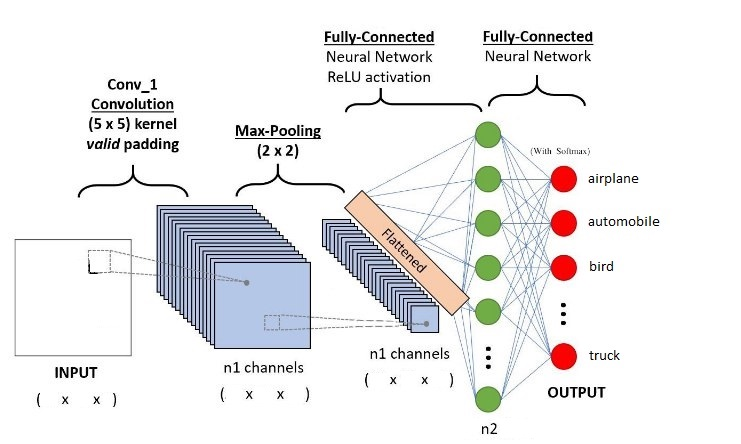

#### **Questions**

- What are the input dimensions?
- What are the dimensions of the feature maps?
- What are the dimensions after pooling?
- What is the size of each input (i.e value of `in_features`) to the first fully connected linear layer?
- What is the number of parameters for conv_1?

**Your answers here**

- 32x32x3
- 28x28x32
- 14x14x32
- $32*((32-4)//2)**2=6272$
- $32*(5*5*3+1)=2432$

In [9]:
# TODO define model
class ConvNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(

            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=5,
                      stride=1),
            nn.MaxPool2d(2, 2),
            nn.ReLU(),

            nn.Flatten(),
            nn.Linear(32*((32-4)//2)**2, 512),
            nn.ReLU(),
            nn.Linear(512, 10)

        )

    def forward(self, xb):
        return self.network(xb)

#### **TODO**

- Train the model for 10 epochs. Try lr=0.001 (can be changed to suit other design choices you make)
- Plot the results of accuracy and loss as you did in exercise sheet 1.

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]           2,432
         MaxPool2d-2           [-1, 32, 14, 14]               0
              ReLU-3           [-1, 32, 14, 14]               0
           Flatten-4                 [-1, 6272]               0
            Linear-5                  [-1, 512]       3,211,776
              ReLU-6                  [-1, 512]               0
            Linear-7                   [-1, 10]           5,130
Total params: 3,219,338
Trainable params: 3,219,338
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.34
Params size (MB): 12.28
Estimated Total Size (MB): 12.64
----------------------------------------------------------------


Finished training after 119 seconds.


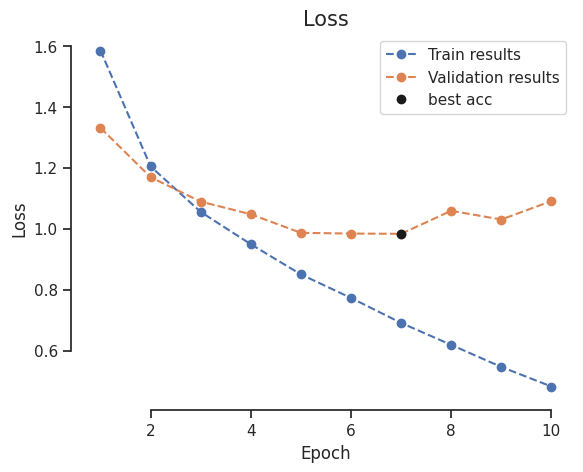

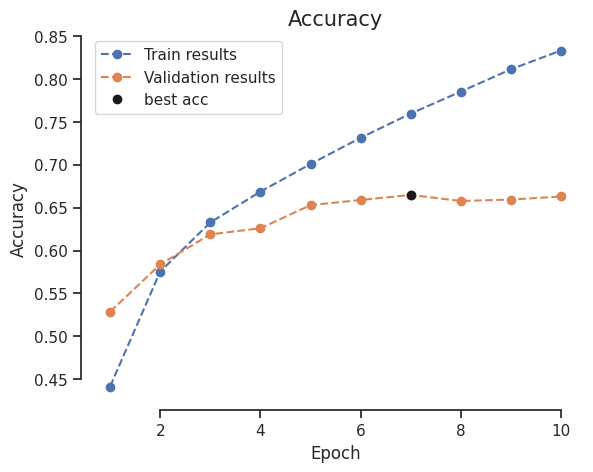

In [ ]:
# TODO train and plot
num_epochs = 10
lr = 1e-3
model = ConvNet().to(device)
summary(model, input_size=(3, 32, 32))
optimizer=optim.Adam(model.parameters(),lr=lr)
loss_function=nn.CrossEntropyLoss()
# earlystop = setup.EarlyStopper(verbose=False, path='checkpoint.pt', patience=20)
train_losses, val_losses, train_accs, val_accs, confusion_matrix= setup.run_training(model, optimizer, loss_function, device, num_epochs,
              trainloader, valloader, early_stopper=None, verbose=False)
setup.plot("Loss","Loss", train_losses, val_losses, extra_pt=(val_accs.index(max(val_accs))+1, val_losses[val_accs.index(max(val_accs))]), extra_pt_label="best acc")
setup.plot("Accuracy","Accuracy", train_accs, val_accs, extra_pt=(val_accs.index(max(val_accs))+1,max(val_accs)), extra_pt_label="best acc")

#### **TODO**
Compare results to the MLP models you trained in Exercise 1. What can you observe?

**Your answers here**

Our CNN model exhibits overfitting similar to what we observed in the NN model. We observe lower loss and higher accuracy in comparison to the NN model.

**For your reference, below is the loss and accuracy plots of an MLP model trained in Exercise sheet 1:**

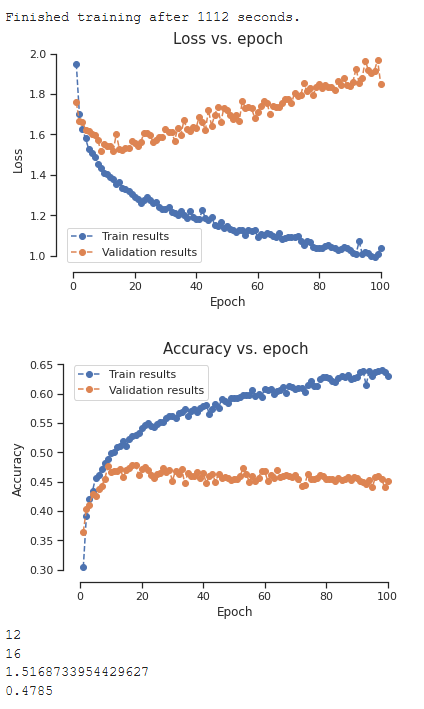

#### **TODO**
Train longer (ca. 60 epochs), plot again.

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]           2,432
         MaxPool2d-2           [-1, 32, 14, 14]               0
              ReLU-3           [-1, 32, 14, 14]               0
           Flatten-4                 [-1, 6272]               0
            Linear-5                  [-1, 512]       3,211,776
              ReLU-6                  [-1, 512]               0
            Linear-7                   [-1, 10]           5,130
Total params: 3,219,338
Trainable params: 3,219,338
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.34
Params size (MB): 12.28
Estimated Total Size (MB): 12.64
----------------------------------------------------------------


Finished training after 712 seconds.


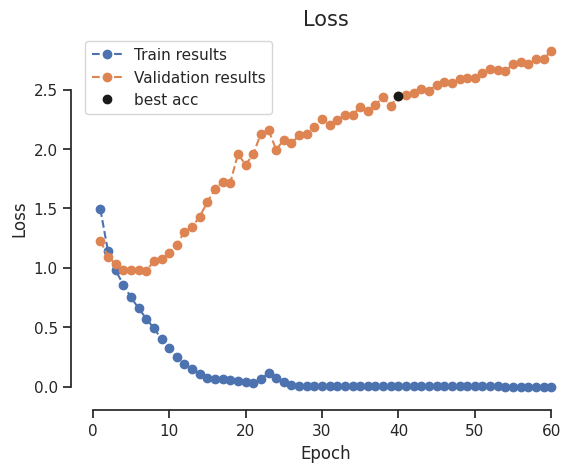

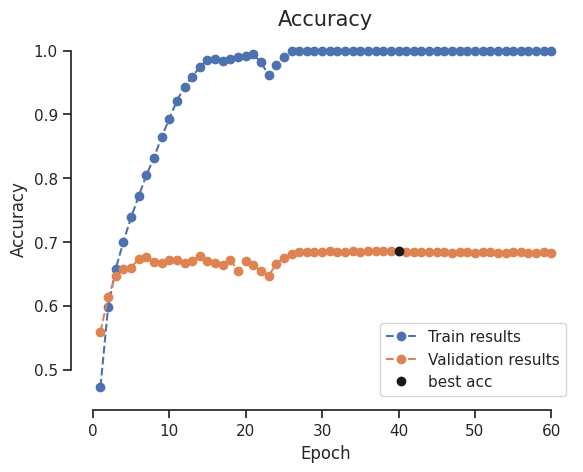

In [ ]:
# TODO train and plot
num_epochs = 60
lr = 1e-3
model = ConvNet().to(device)
summary(model, input_size=(3, 32, 32))
optimizer=optim.Adam(model.parameters(),lr=lr)
loss_function=nn.CrossEntropyLoss()
# earlystop = setup.EarlyStopper(verbose=False, path='checkpoint.pt', patience=20)
train_losses, val_losses, train_accs, val_accs, confusion_matrix= setup.run_training(model, optimizer, loss_function, device, num_epochs,
              trainloader, valloader, early_stopper=None, verbose=False)
setup.plot("Loss","Loss", train_losses, val_losses, extra_pt=(val_accs.index(max(val_accs))+1, val_losses[val_accs.index(max(val_accs))]), extra_pt_label="best acc")
setup.plot("Accuracy","Accuracy", train_accs, val_accs, extra_pt=(val_accs.index(max(val_accs))+1,max(val_accs)), extra_pt_label="best acc")

#### **Questions**
- Why is that not an optimal model?
- What could be improved?

**Your answers here**

- Only one CNN layer is not capable of learning higher-level/intermediate features and for the dataset of CIFAR, better classifications are expected to achieved with models with more layers.

- Adding more layer CNN and NN layers to allow the model learn all levels features of the latent space.

## 4. CNN model with more convolutional layers

#### **TODO**
Define the architecture using the following information:



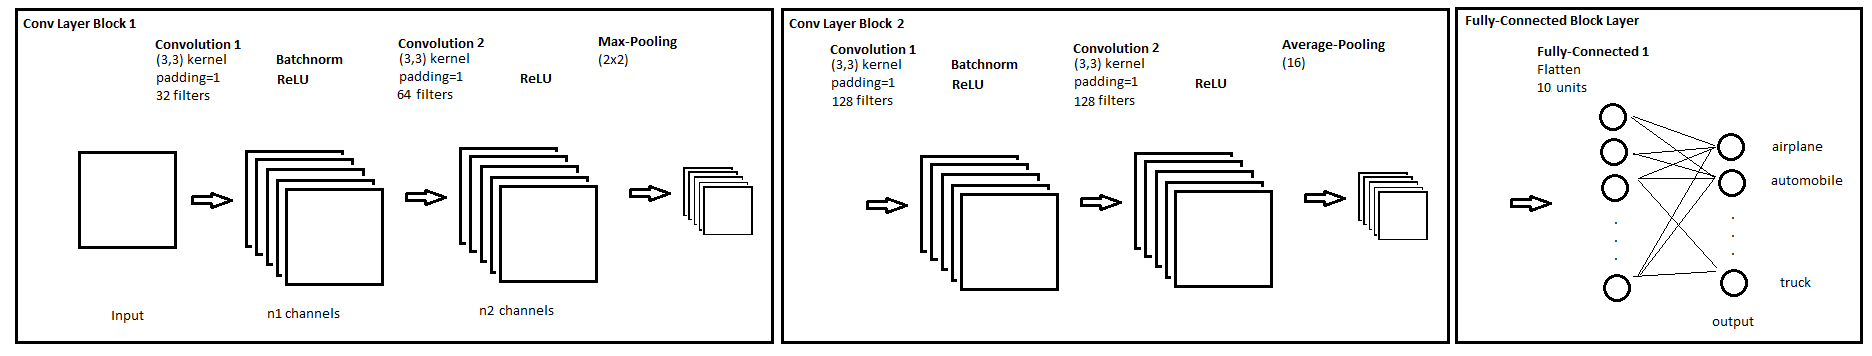

*   Convolutional layer 1: with 32 filters, kernel size of 3*3 and padding 1.
*   Batchnorm and ReLU layers
*   Convolutional layer 2: with 64 filters, kernel size of 3*3 and padding 1.
*   ReLU Activation layer
*   Max pooling with kernel size of 2*2
*   Convolutional layer 3: with 128 filters, kernel size of 3*3 and padding 1.
*   Batchnorm and ReLU layers
*   Convolutional layer 4: with 128 filters, kernel size of 3*3 and padding 1.
*   ReLU Activation layer
*   Average pooling with kernel size 16*16
*   Fully connected layer

#### **Questions**

- Padding is used in the convolutional layers. What does that mean, which variants exist and how does it influence the dimensions of the feature maps?
- What does padding=1 mean in the case of the network displayed above?
- What are the dimensions of the feature maps after the 1. conv layer?
- What are the dimensions of the feature maps after the 2. conv layer?
- What ist the receptive field size after the first two convolutions?
- What is the value for the in_features for the fully-connected layer?
- What is the number of parameters of *Conv Layer block 1*?

**Your answers here**

- Padding preserves the spatial dimensions of the 2D image after convolution operations on a feature map. Padding involves adding extra pixels around the border of the input feature map before convolution. This technique aids in preventing any information loss from the edge of images.

- The padding parameter will expand the shape of the convolved image with zeros to all four sides of the input. So padding=1 means that the shape of the input image is extended by one zero-value pixel from all four sides.

- Starting from a [3x32x32] input data, after convolution layer of with kernel=(3,3), and output_channel=32, we get [32x32x32]

- After two convolution layers, the dimension of output is [64x32x32]

- Following the formula given in https://distill.pub/2019/computing-receptive-fields/ , we compute the size of receptive field using $$ r_{0} = [\sum_{l=1}^{L} (k_{l}-1) \prod_{i=1}^{l-1} s_{i} ] +1$$ where $k_{l}$ denotes kernel size at layer $l$, $s_{i}$ is the stride size at layer $i$. For the first two conv-layers, strides are one, and we have two 3x3 kernel sizes. Hence, the size of the receptive field is $(2+2)+1=5$.

- in_features=128 in the last dense layer.

- The number of parameters in the first conv-layer is 32x3x3x3+32=864+32=896.

In [10]:
#TODO define model 2
class ConvNet2(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            # Convolutional layer 1
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),

            # Convolutional layer 2
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),

            # Convolutional layer 3
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),

            # Convolutional layer 4
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=16),

            # Flatten for fully connected layer
            nn.Flatten(),

            # Fully connected layer
            nn.Linear(128, 10)
        )
    def forward(self, x):
        return self.model(x)




#### **TODO**

- train the new net (30 epochs, try lr=0.1 or change as necessary), plot the results, and compare the results to the 1-layer CNN
- explain why you observe these results

learning rate:  0.1
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             896
       BatchNorm2d-2           [-1, 32, 32, 32]              64
              ReLU-3           [-1, 32, 32, 32]               0
            Conv2d-4           [-1, 64, 32, 32]          18,496
              ReLU-5           [-1, 64, 32, 32]               0
         MaxPool2d-6           [-1, 64, 16, 16]               0
            Conv2d-7          [-1, 128, 16, 16]          73,856
       BatchNorm2d-8          [-1, 128, 16, 16]             256
              ReLU-9          [-1, 128, 16, 16]               0
           Conv2d-10          [-1, 128, 16, 16]         147,584
             ReLU-11          [-1, 128, 16, 16]               0
        AvgPool2d-12            [-1, 128, 1, 1]               0
          Flatten-13                  [-1, 128]               0
           Linear-1

Finished training after 608 seconds.


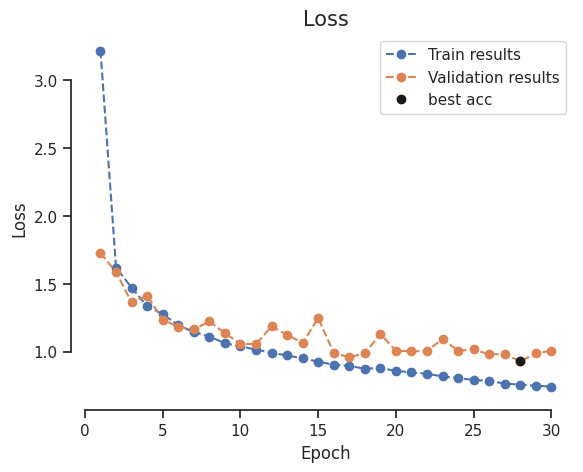

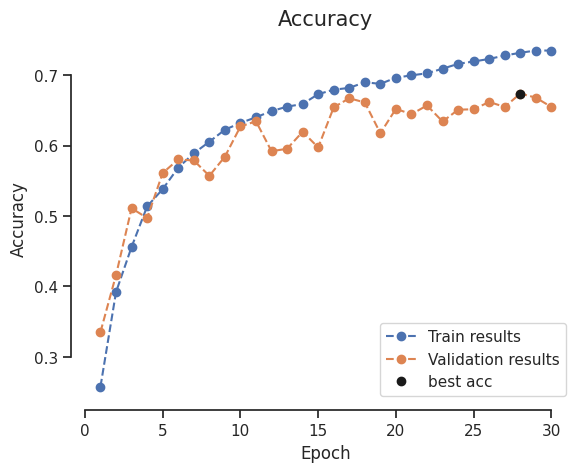

Lowest Loss.= 0.9285194158554078
Max Accu.= 0.6738
learning rate:  0.001
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             896
       BatchNorm2d-2           [-1, 32, 32, 32]              64
              ReLU-3           [-1, 32, 32, 32]               0
            Conv2d-4           [-1, 64, 32, 32]          18,496
              ReLU-5           [-1, 64, 32, 32]               0
         MaxPool2d-6           [-1, 64, 16, 16]               0
            Conv2d-7          [-1, 128, 16, 16]          73,856
       BatchNorm2d-8          [-1, 128, 16, 16]             256
              ReLU-9          [-1, 128, 16, 16]               0
           Conv2d-10          [-1, 128, 16, 16]         147,584
             ReLU-11          [-1, 128, 16, 16]               0
        AvgPool2d-12            [-1, 128, 1, 1]               0
          Flatten-13          

Finished training after 601 seconds.


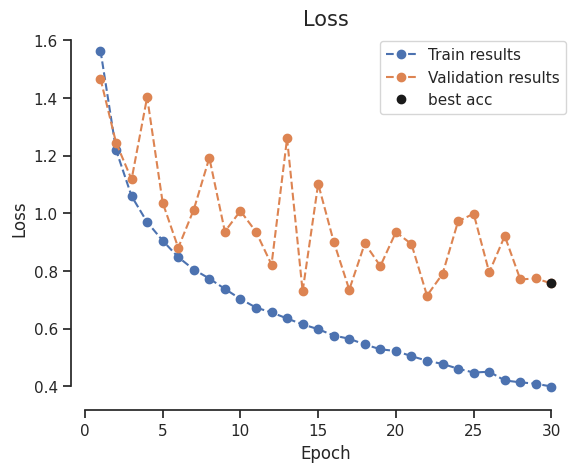

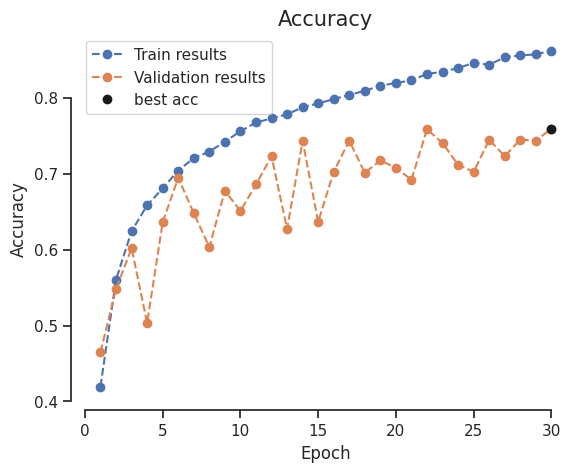

Lowest Loss.= 0.7142659649252892
Max Accu.= 0.7594


In [11]:
# TODO train and plot
num_epochs = 30
for lr in [1e-1, 1e-3]:
    print("learning rate: ", lr)
    model2 = ConvNet2().to(device)
    summary(model2, input_size=(3, 32, 32))
    optimizer=optim.Adam(model2.parameters(),lr=lr)
    loss_function=nn.CrossEntropyLoss()
    # earlystop = setup.EarlyStopper(verbose=False, path='checkpoint.pt', patience=10)
    train_losses, val_losses, train_accs, val_accs, confusion_matrix= setup.run_training(model2, optimizer, loss_function, device, num_epochs,
                  trainloader, valloader, early_stopper=None, verbose=False)
    setup.plot("Loss","Loss", train_losses, val_losses, extra_pt=(val_accs.index(max(val_accs))+1, val_losses[val_accs.index(max(val_accs))]), extra_pt_label="best acc")
    setup.plot("Accuracy","Accuracy", train_accs, val_accs, extra_pt=(val_accs.index(max(val_accs))+1,max(val_accs)), extra_pt_label="best acc")

    print("Lowest Loss.=", min(val_losses))
    print("Max Accu.=", max(val_accs))

## 5. ResNet architecture

"*Deeper neural networks are more difficult to train.  We present a residual learning framework to ease the training of networks that are substantially deeper than those used previously.*" [ https://arxiv.org/pdf/1512.03385.pdf]

That was the intention of He et al. to develop residual networks.

A ResNet is built of blocks which are called the *Residual Blocks*.
A residual block uses *skip connections* - shortCuts — to jump over some layers to skip some activations.
The Resnet skips connections via addition.

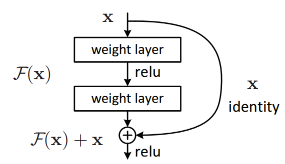

#### **Questions**
- Which problems do using skip connections solve?
- Why is a residual network called residual?

**Your answers here**

- The skip connections in deep architecture bypass some of the neural network layers and feed the output of one layer as the input to the following levels.
The skip connections were used to solve the degradation problems. The degradation problem refers to the model's performance degrading as the architecture's load increases. The major reasons for the degradation problem are overfitting or the depth of the model in general because a model with more layers has more training errors compared to the shallower models. Another explanation might be disappearing gradients and/or exploding gradient issues.

- The layers in a traditional network are learning the true output, whereas the layers in a residual network are learning the residual of inputs.

#### **TODO**
- write a class **ResidualBlock(nn.Module)** where you define the blocks used in the ResNet
- write a class **ResNet(nn.Module)** where you define the model
- Train the model and plot results
- Train another model by disable residual connections and compare performance

**Hints**

- The downsampling in this ResNet happens between layer 1 and layer 2. In this step, the channel size is increased (32 -> 64) and the image resolution is downsampled by strided convolution (stride=2 in the Conv2d layers).
- For the adding part, the dimensions obviously have to be the same. This is accomplished by using stride=2 in the first Conv2d layer of the block while the second layer does not change the dimensions.
- The average-pooling layer has kernel size 7.
- For you to ensure everything works fine, here are the shapes in the form [(batchsize), x, y, channel] where I discard batchsize, because it does not change.
32x32x3 -> conv 7x7 -> 14x14x32 -> layer 1 -> 14x14x32 -> layer2 -> 7x7x64 -> avpool(7) -> 1x1x64 -> linear(64, 10)

In [ ]:
# TODO write a class ResidualBlock(nn.Module) where you define the blocks used in the ResNet

# Residual block
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, downsample=None):
        super(ResidualBlock, self).__init__()

        self.out_channels=out_channels
        self.downsample = downsample

        if self.downsample:
            self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3,
                     stride=2, padding=1)
        else:
            self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3,
                     stride=1, padding=1)

        self.bn1 = nn.BatchNorm2d(self.out_channels)
        self.relu = nn.ReLU()

        self.conv2 = nn.Conv2d(self.out_channels, self.out_channels, kernel_size=3,
                     stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(self.out_channels)
        self.relu2 = nn.ReLU()


    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        if self.downsample:
            residual = self.downsample(x)
        out += residual
        out = self.relu2(out)
        return out

In [ ]:
# TODO write a class ResidualBlock(nn.Module) where you define the blocks used in the ResNet

# Residual block
class ResidualBlock_noresidual(nn.Module):
    def __init__(self, in_channels, out_channels, downsample=None):
        super(ResidualBlock_noresidual, self).__init__()

        self.out_channels=out_channels
        self.downsample = downsample

        if self.downsample:
            self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3,
                     stride=2, padding=1)
        else:
            self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3,
                     stride=1, padding=1)

        self.bn1 = nn.BatchNorm2d(self.out_channels)
        self.relu = nn.ReLU()

        self.conv2 = nn.Conv2d(self.out_channels, self.out_channels, kernel_size=3,
                     stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(self.out_channels)
        self.relu2 = nn.ReLU()


    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
#         if self.downsample:
#             residual = self.downsample(x)
#         out += residual
        out = self.relu2(out)
        return out

In [ ]:
#check summary of the residual block model
restest=ResidualBlock(in_channels=32, out_channels=32).to(device)
summary(restest, input_size=(32,14,14))

restest=ResidualBlock_noresidual(in_channels=32, out_channels=32).to(device)
summary(restest, input_size=(32,14,14))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 14, 14]           9,248
       BatchNorm2d-2           [-1, 32, 14, 14]              64
              ReLU-3           [-1, 32, 14, 14]               0
            Conv2d-4           [-1, 32, 14, 14]           9,248
       BatchNorm2d-5           [-1, 32, 14, 14]              64
              ReLU-6           [-1, 32, 14, 14]               0
Total params: 18,624
Trainable params: 18,624
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.02
Forward/backward pass size (MB): 0.29
Params size (MB): 0.07
Estimated Total Size (MB): 0.38
----------------------------------------------------------------
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 14,

In [ ]:
# TODO write a class ResNet(nn.Module) where you define the model
class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=10):
        super(ResNet, self).__init__()
        self.in_channels = 32
        self.block = block

        self.conv = nn.Conv2d(3, 32, kernel_size=7,
                     stride=2, padding=1) # ((W)32-(Kernel)7+1)/2(stride)=14 => 14x14x32
        self.bn = nn.BatchNorm2d(32)
        self.relu = nn.ReLU()
        sizelinearlayer = 2*2*32

        if block !=None:
            self.layer1 = self.make_layer(block, 32, layers[0],stride=1) #14x14x32
            self.layer2 = self.make_layer(block, 64, layers[1],stride=2)#7*7*64
            sizelinearlayer = 1*1*64
        print(sizelinearlayer)

        self.avg_pool = nn.AvgPool2d(7)  #after layer2: 1x1x64 withoutlayer 2: 2*2*32

        self.fc = nn.Linear(sizelinearlayer, num_classes)

    def make_layer(self, block, out_channels, blocks, stride=1):
        downsample = None
        if (stride != 1) or (self.in_channels != out_channels):
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels, kernel_size=3,
                          stride=stride , padding=1),
                nn.BatchNorm2d(out_channels))
        layers = []
        layers.append(block(self.in_channels, out_channels, downsample))
        self.in_channels = out_channels
        for i in range(1, blocks):
            layers.append(block(out_channels, out_channels, downsample=None))
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv(x)
        out = self.bn(out)
        out = self.relu(out)
        if self.block != None:
            out = self.layer1(out)
            out = self.layer2(out)
        out = self.avg_pool(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

64
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 14, 14]           4,736
       BatchNorm2d-2           [-1, 32, 14, 14]              64
              ReLU-3           [-1, 32, 14, 14]               0
            Conv2d-4           [-1, 32, 14, 14]           9,248
       BatchNorm2d-5           [-1, 32, 14, 14]              64
              ReLU-6           [-1, 32, 14, 14]               0
            Conv2d-7           [-1, 32, 14, 14]           9,248
       BatchNorm2d-8           [-1, 32, 14, 14]              64
              ReLU-9           [-1, 32, 14, 14]               0
    ResidualBlock-10           [-1, 32, 14, 14]               0
           Conv2d-11           [-1, 32, 14, 14]           9,248
      BatchNorm2d-12           [-1, 32, 14, 14]              64
             ReLU-13           [-1, 32, 14, 14]               0
           Conv2d-14           [-1, 

Finished training after 390 seconds.


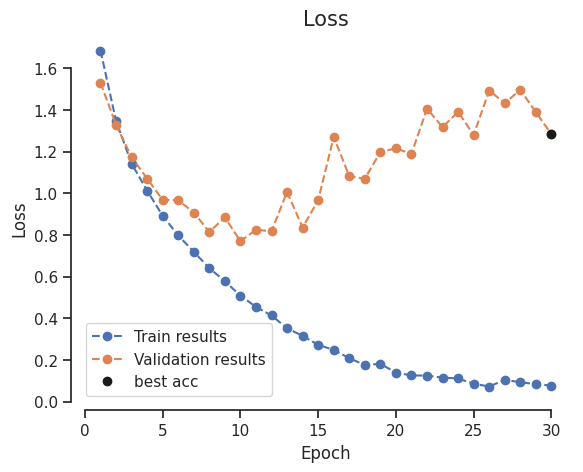

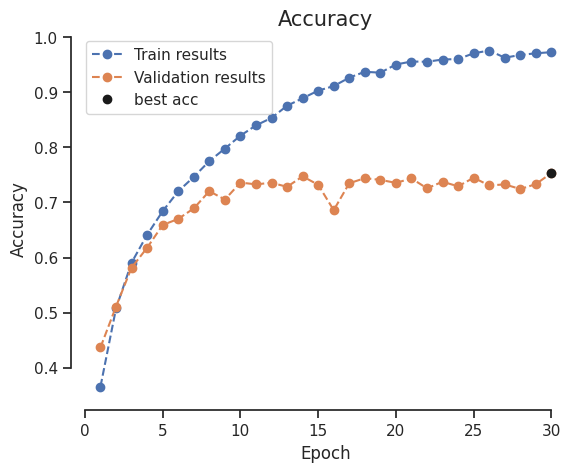

Lowest Loss.= 0.7705655913800001
Max Accu.= 0.7533
64
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 14, 14]           4,736
       BatchNorm2d-2           [-1, 32, 14, 14]              64
              ReLU-3           [-1, 32, 14, 14]               0
            Conv2d-4           [-1, 32, 14, 14]           9,248
       BatchNorm2d-5           [-1, 32, 14, 14]              64
              ReLU-6           [-1, 32, 14, 14]               0
            Conv2d-7           [-1, 32, 14, 14]           9,248
       BatchNorm2d-8           [-1, 32, 14, 14]              64
              ReLU-9           [-1, 32, 14, 14]               0
    ResidualBlock-10           [-1, 32, 14, 14]               0
           Conv2d-11           [-1, 32, 14, 14]           9,248
      BatchNorm2d-12           [-1, 32, 14, 14]              64
             ReLU-13           [-1, 32, 14, 14]  

Finished training after 392 seconds.


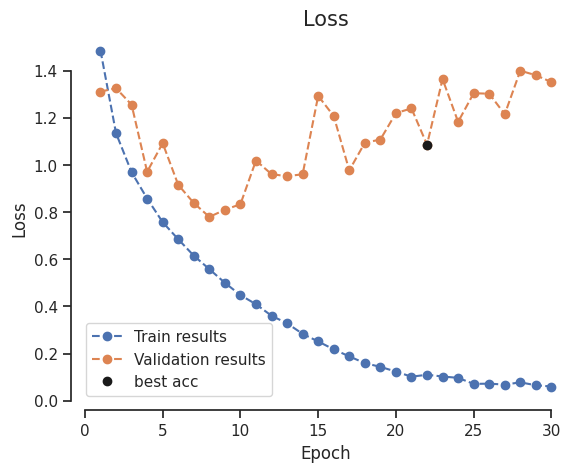

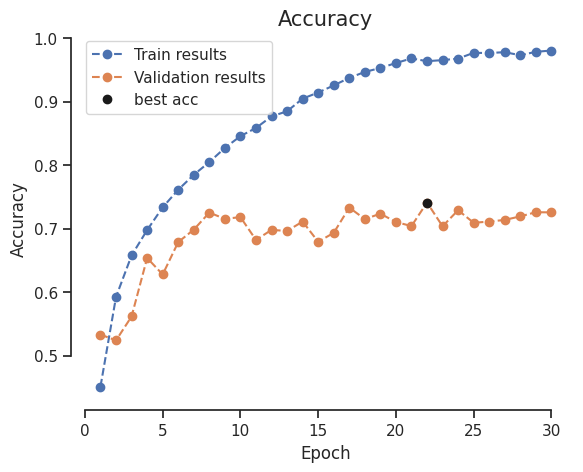

Lowest Loss.= 0.7797370865941048
Max Accu.= 0.7414
64
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 14, 14]           4,736
       BatchNorm2d-2           [-1, 32, 14, 14]              64
              ReLU-3           [-1, 32, 14, 14]               0
            Conv2d-4           [-1, 32, 14, 14]           9,248
       BatchNorm2d-5           [-1, 32, 14, 14]              64
              ReLU-6           [-1, 32, 14, 14]               0
            Conv2d-7           [-1, 32, 14, 14]           9,248
       BatchNorm2d-8           [-1, 32, 14, 14]              64
              ReLU-9           [-1, 32, 14, 14]               0
    ResidualBlock-10           [-1, 32, 14, 14]               0
           Conv2d-11           [-1, 32, 14, 14]           9,248
      BatchNorm2d-12           [-1, 32, 14, 14]              64
             ReLU-13           [-1, 32, 14, 14]  

Finished training after 390 seconds.


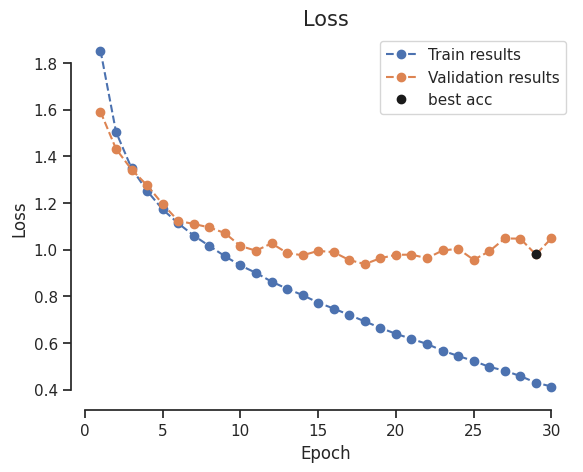

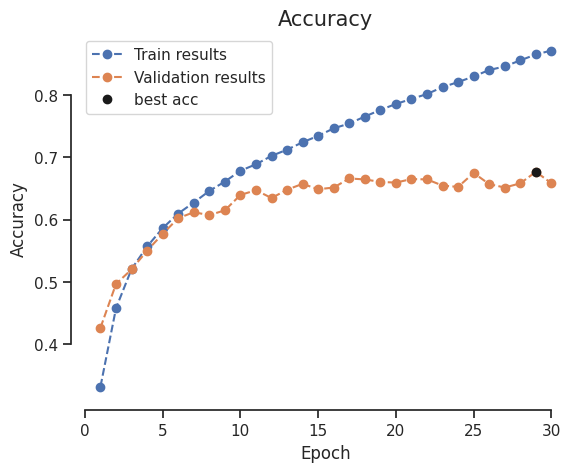

Lowest Loss.= 0.938374149799347
Max Accu.= 0.6767


In [ ]:
# TODO train ResNet using the architecture laid out in the comments and figures above. Plot loss and accuracy for training and validation set.
num_epochs = 30
lr = 0.001

for lr in [1e-2, 1e-3, 1e-4]:
    # Loss and optimizer
    model = ResNet(block=ResidualBlock, layers=[2, 2]).to(device)
    summary(model, input_size=(3,32,32))
    optimizer=optim.Adam(model.parameters(),lr=lr)
    loss_function=nn.CrossEntropyLoss()


    train_losses, val_losses, train_accs, val_accs, confusion_matrix= setup.run_training(model, optimizer, loss_function, device, num_epochs,
                      trainloader, valloader, early_stopper=None, verbose=False)
    setup.plot("Loss","Loss", train_losses, val_losses, extra_pt=(val_accs.index(max(val_accs))+1, val_losses[val_accs.index(max(val_accs))]), extra_pt_label="best acc")
    setup.plot("Accuracy","Accuracy", train_accs, val_accs, extra_pt=(val_accs.index(max(val_accs))+1,max(val_accs)), extra_pt_label="best acc")

    print("Lowest Loss.=", min(val_losses))
    print("Max Accu.=", max(val_accs))


64
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [256, 32, 14, 14]           4,736
       BatchNorm2d-2          [256, 32, 14, 14]              64
              ReLU-3          [256, 32, 14, 14]               0
            Conv2d-4          [256, 32, 14, 14]           9,248
       BatchNorm2d-5          [256, 32, 14, 14]              64
              ReLU-6          [256, 32, 14, 14]               0
            Conv2d-7          [256, 32, 14, 14]           9,248
       BatchNorm2d-8          [256, 32, 14, 14]              64
              ReLU-9          [256, 32, 14, 14]               0
ResidualBlock_noresidual-10          [256, 32, 14, 14]               0
           Conv2d-11          [256, 32, 14, 14]           9,248
      BatchNorm2d-12          [256, 32, 14, 14]              64
             ReLU-13          [256, 32, 14, 14]               0
           Conv2d-14         

Finished training after 386 seconds.


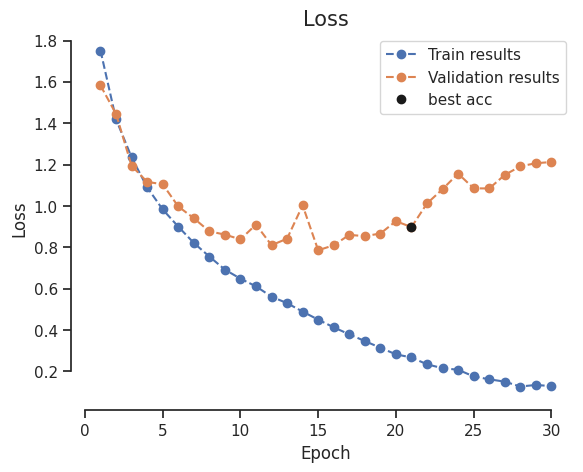

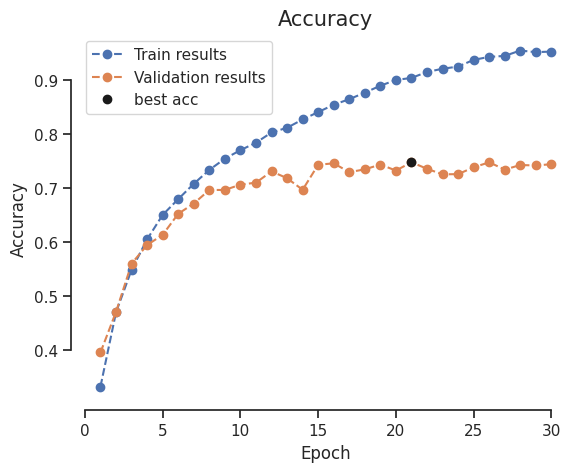

Lowest Loss.= 0.7858884282410145
Max Accu.= 0.7482
64
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [256, 32, 14, 14]           4,736
       BatchNorm2d-2          [256, 32, 14, 14]              64
              ReLU-3          [256, 32, 14, 14]               0
            Conv2d-4          [256, 32, 14, 14]           9,248
       BatchNorm2d-5          [256, 32, 14, 14]              64
              ReLU-6          [256, 32, 14, 14]               0
            Conv2d-7          [256, 32, 14, 14]           9,248
       BatchNorm2d-8          [256, 32, 14, 14]              64
              ReLU-9          [256, 32, 14, 14]               0
ResidualBlock_noresidual-10          [256, 32, 14, 14]               0
           Conv2d-11          [256, 32, 14, 14]           9,248
      BatchNorm2d-12          [256, 32, 14, 14]              64
             ReLU-13          [256, 32, 14

Finished training after 387 seconds.


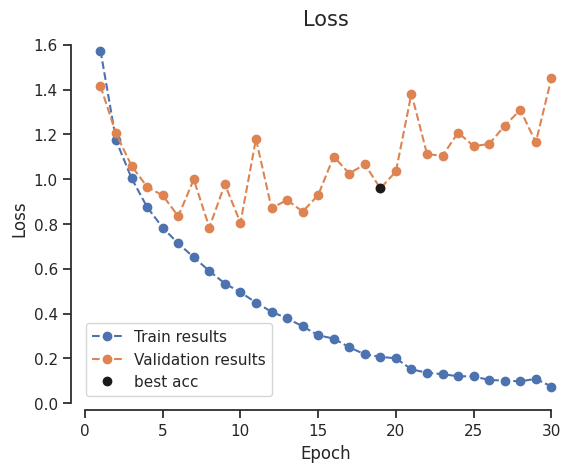

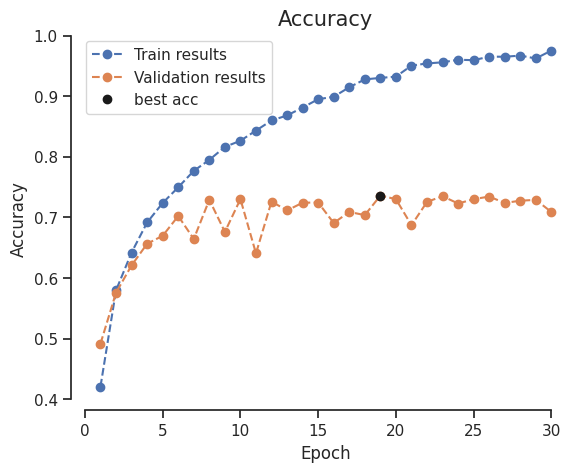

Lowest Loss.= 0.7841838002204895
Max Accu.= 0.736
64
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [256, 32, 14, 14]           4,736
       BatchNorm2d-2          [256, 32, 14, 14]              64
              ReLU-3          [256, 32, 14, 14]               0
            Conv2d-4          [256, 32, 14, 14]           9,248
       BatchNorm2d-5          [256, 32, 14, 14]              64
              ReLU-6          [256, 32, 14, 14]               0
            Conv2d-7          [256, 32, 14, 14]           9,248
       BatchNorm2d-8          [256, 32, 14, 14]              64
              ReLU-9          [256, 32, 14, 14]               0
ResidualBlock_noresidual-10          [256, 32, 14, 14]               0
           Conv2d-11          [256, 32, 14, 14]           9,248
      BatchNorm2d-12          [256, 32, 14, 14]              64
             ReLU-13          [256, 32, 14,

Finished training after 385 seconds.


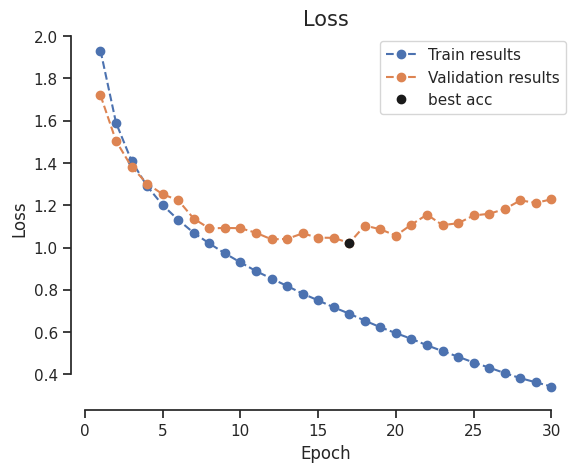

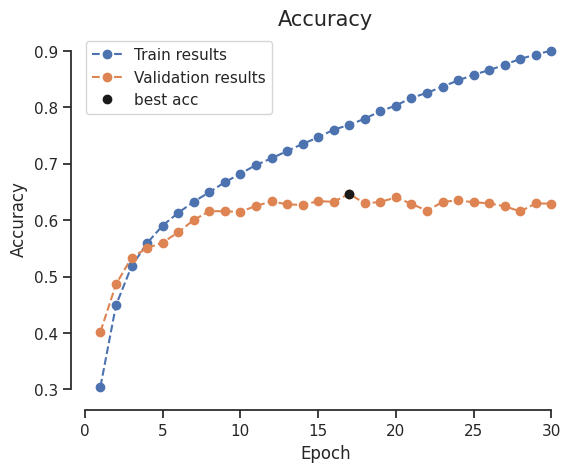

Lowest Loss.= 1.021290411055088
Max Accu.= 0.6466


In [ ]:
# TODO Train another model by disabling all residual connections. Plot loss and accuracy curves for training and validation set.

for lr in [1e-2, 1e-3, 1e-4]:
    # Loss and optimizer
    model = ResNet(block=ResidualBlock_noresidual, layers=[2, 2]).to(device)
    summary(model, input_size=(3,32,32), batch_size=batch_size)
    loss_function=nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)


    train_losses, val_losses, train_accs, val_accs, confusion_matrix= setup.run_training(model, optimizer, loss_function, device, num_epochs,
                      trainloader, valloader, early_stopper=None, verbose=False)
    setup.plot("Loss","Loss", train_losses, val_losses, extra_pt=(val_accs.index(max(val_accs))+1, val_losses[val_accs.index(max(val_accs))]), extra_pt_label="best acc")
    setup.plot("Accuracy","Accuracy", train_accs, val_accs, extra_pt=(val_accs.index(max(val_accs))+1,max(val_accs)), extra_pt_label="best acc")

    print("Lowest Loss.=", min(val_losses))
    print("Max Accu.=", max(val_accs))

#### **Questions**
- Does using residual connections result in better performance in this exercise? If yes, why? If not, when would the benefit of using ResNet be most visible?
- In deeper networks, how would you expect residual blocks to influence training time? why?
- Compare the performance and training time of your ResNet with the CNNs you trained in the previous section.

**Your answers here**

- We did not observe better accuracy or smaller loss by comparing accuracies obtained from both models with and without residual connections in ResNet.

- Residual blocks reduce the training error in deep networks. Hence, our models become more effective an trains faster.

- We did not observe better accuracy or smaller loss by comparing accuracies obtained from our ResNet and multi-conv layer above(AlexNet). We, however, realize that the total number of parameters trained in our initial multi-conv layer (242,442) is more than the trained parameters (191,114) in our ResNet model. This is nicely reflected in the training time, which is 390 seconds for the ResNet and 450 for the other Cov-nn.

## 6. Explore Learning Rate Scheduling

Learning rate scheduling is a mechanism to adjust the learning rate.

*`torch.optim.lr_scheduler`* provides several methods based on the number of epochs. Learning rate scheduling should be applied after optimizer’s update.

#### **TODO**
- change run_training and extend to use scheduler for learning rate
- use StepLR (https://pytorch.org/docs/stable/optim.html), use the ResNet, train for 10 epochs. Start with a learning rate of 0.1.


#### **Questions**

- Try step size 1, gamma 0.1
    - How does it change the learning rate?
    - what do you observe regarding performance?
- Try step size 1, gamma 0.9, what do you observe?
    - How does it change the learning rate?
    - what do you observe regarding performance?
- What can you conclude of this experiment regarding the synergy of step size and gamma to get a good schedule?

**Your answers here**

- In the step size=1 and gamma=0.1, the lr after each step is multiplied by 0.1. This results in ending up with $lr=(initial lr) * (0.1)^{\rm num-epochs}$ after epochs=num_epochs. Because of these small learning rates, the model was not trained.

- In the step size=1 and gamma=0.9, the lr after each step is multiplied by 0.9. This results in ending up with $lr=(initial lr) * (0.9)^{\rm num-epochs}$ after epochs=num_epochs. In this case, if our model without scheduler experiences overfitting, we most likely detect overfitting in this case as well.

- It is best not to reduce lr drastically, e.g., gamma=0.1, in every step, but instead multiply the learning rate by tiny amounts like gamma=0.7 to avoid ending up with tiny learning rates at early stages of training.

In [ ]:
# TODO change run_training (you can copy the code from setup.py here and create a new method here
# or just change/create a new method it in the python file)

def run_training_StepLR(model, optimizer, loss_function, device, num_epochs,
                train_dataloader, val_dataloader, early_stopper=None, verbose=False,
                             step_size=1, gamma=0.8):
    """Run model training.

    Args:
        model (nn.Module): Torch model to train
        optimizer: Torch optimizer object
        loss_fn: Torch loss function for training
        device (torch.device): Torch device to use for training
        num_epochs (int): Max. number of epochs to train
        train_dataloader (DataLoader): Torch DataLoader object to load the
            training data
        val_dataloader (DataLoader): Torch DataLoader object to load the
            validation data
        early_stopper (EarlyStopper, optional): If passed, model will be trained
            with early stopping. Defaults to None.
        verbose (bool, optional): Print information about model training.
            Defaults to False.

    Returns:
        list, list, list, list, torch.Tensor shape (10,10): Return list of train
            losses, validation losses, train accuracies, validation accuracies
            per epoch and the confusion matrix evaluated in the last epoch.
    """
    start_time = time.time()
    master_bar = fastprogress.master_bar(range(num_epochs))
    train_losses, val_losses, train_accs, val_accs = [],[],[],[]

    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size, gamma, verbose=True)
    for epoch in master_bar:
        # Train the model
        epoch_train_loss, epoch_train_acc = setup.train(train_dataloader, optimizer, model,
                                                  loss_function, device, master_bar)
        scheduler.step()
        # Validate the model
        epoch_val_loss, epoch_val_acc, confusion_matrix = setup.validate(val_dataloader,
                                                                   model, loss_function,
                                                                   device, master_bar)

        # Save loss and acc for plotting
        train_losses.append(epoch_train_loss)
        val_losses.append(epoch_val_loss)
        train_accs.append(epoch_train_acc)
        val_accs.append(epoch_val_acc)

        if verbose:
            master_bar.write(f'Train loss: {epoch_train_loss:.2f}, val loss: {epoch_val_loss:.2f}, train acc: {epoch_train_acc:.3f}, val acc {epoch_val_acc:.3f}')

        if early_stopper:
            early_stopper.update(epoch_val_acc, model)
            if early_stopper.early_stop:
                model = early_stopper.load_checkpoint(model)
                print('early stopping')
                break
            # END OF YOUR CODE #

    time_elapsed = np.round(time.time() - start_time, 0).astype(int)
    print(f'Finished training after {time_elapsed} seconds.')
    return train_losses, val_losses, train_accs, val_accs, confusion_matrix


64
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 14, 14]           4,736
       BatchNorm2d-2           [-1, 32, 14, 14]              64
              ReLU-3           [-1, 32, 14, 14]               0
            Conv2d-4           [-1, 32, 14, 14]           9,248
       BatchNorm2d-5           [-1, 32, 14, 14]              64
              ReLU-6           [-1, 32, 14, 14]               0
            Conv2d-7           [-1, 32, 14, 14]           9,248
       BatchNorm2d-8           [-1, 32, 14, 14]              64
              ReLU-9           [-1, 32, 14, 14]               0
    ResidualBlock-10           [-1, 32, 14, 14]               0
           Conv2d-11           [-1, 32, 14, 14]           9,248
      BatchNorm2d-12           [-1, 32, 14, 14]              64
             ReLU-13           [-1, 32, 14, 14]               0
           Conv2d-14           [-1, 

Adjusting learning rate of group 0 to 1.0000e-02.
Adjusting learning rate of group 0 to 1.0000e-03.
Adjusting learning rate of group 0 to 1.0000e-04.
Adjusting learning rate of group 0 to 1.0000e-05.
Adjusting learning rate of group 0 to 1.0000e-06.
Adjusting learning rate of group 0 to 1.0000e-07.
Adjusting learning rate of group 0 to 1.0000e-08.
Adjusting learning rate of group 0 to 1.0000e-09.
Adjusting learning rate of group 0 to 1.0000e-10.
Adjusting learning rate of group 0 to 1.0000e-11.
Finished training after 130 seconds.


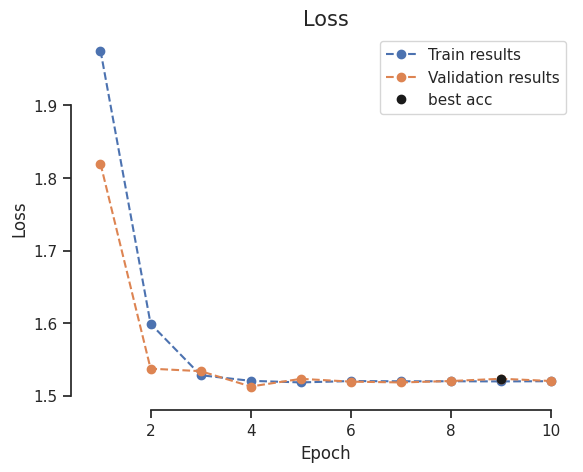

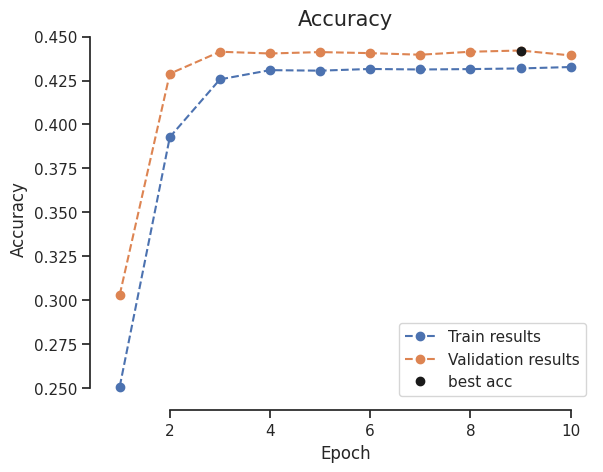

Lowest Loss.= 1.5128061830997468
Max Accu.= 0.4421
64
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 14, 14]           4,736
       BatchNorm2d-2           [-1, 32, 14, 14]              64
              ReLU-3           [-1, 32, 14, 14]               0
            Conv2d-4           [-1, 32, 14, 14]           9,248
       BatchNorm2d-5           [-1, 32, 14, 14]              64
              ReLU-6           [-1, 32, 14, 14]               0
            Conv2d-7           [-1, 32, 14, 14]           9,248
       BatchNorm2d-8           [-1, 32, 14, 14]              64
              ReLU-9           [-1, 32, 14, 14]               0
    ResidualBlock-10           [-1, 32, 14, 14]               0
           Conv2d-11           [-1, 32, 14, 14]           9,248
      BatchNorm2d-12           [-1, 32, 14, 14]              64
             ReLU-13           [-1, 32, 14, 14]  

Adjusting learning rate of group 0 to 1.0000e-03.
Adjusting learning rate of group 0 to 1.0000e-04.
Adjusting learning rate of group 0 to 1.0000e-05.
Adjusting learning rate of group 0 to 1.0000e-06.
Adjusting learning rate of group 0 to 1.0000e-07.
Adjusting learning rate of group 0 to 1.0000e-08.
Adjusting learning rate of group 0 to 1.0000e-09.
Adjusting learning rate of group 0 to 1.0000e-10.
Adjusting learning rate of group 0 to 1.0000e-11.
Adjusting learning rate of group 0 to 1.0000e-12.
Finished training after 131 seconds.


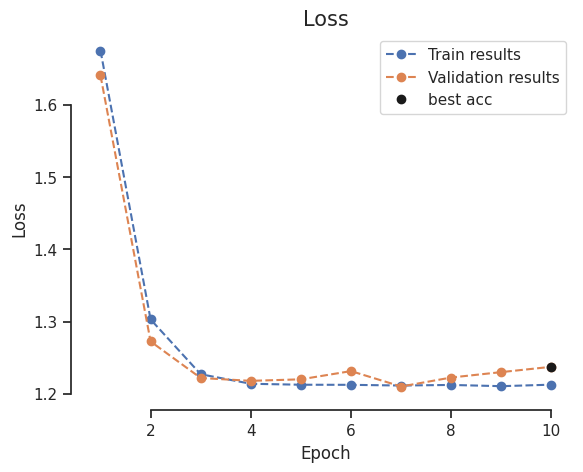

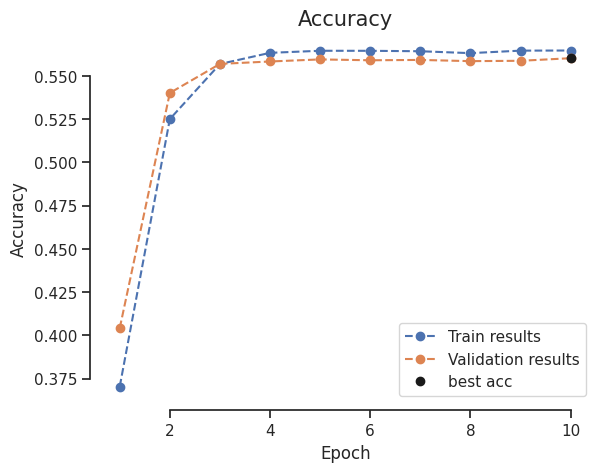

Lowest Loss.= 1.2101174846291542
Max Accu.= 0.5603


In [ ]:
# TODO train and plot with step size 1, gamma 0.1

# TODO train ResNet using the architecture laid out in the comments and figures above. Plot loss and accuracy for training and validation set.

num_epochs =10
for lr in [0.1, 0.01]:
    # Loss and optimizer
    model = ResNet(block=ResidualBlock, layers=[2, 2]).to(device)
    summary(model, input_size=(3,32,32))
    optimizer=optim.Adam(model.parameters(),lr=lr)
    loss_function=nn.CrossEntropyLoss()


    train_losses, val_losses, train_accs, val_accs, confusion_matrix= run_training_StepLR(model, optimizer, loss_function, device, num_epochs,
                      trainloader, valloader, early_stopper=None, verbose=False, step_size=1, gamma=0.1)
    setup.plot("Loss","Loss", train_losses, val_losses, extra_pt=(val_accs.index(max(val_accs))+1, val_losses[val_accs.index(max(val_accs))]), extra_pt_label="best acc")
    setup.plot("Accuracy","Accuracy", train_accs, val_accs, extra_pt=(val_accs.index(max(val_accs))+1,max(val_accs)), extra_pt_label="best acc")

    print("Lowest Loss.=", min(val_losses))
    print("Max Accu.=", max(val_accs))


64
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 14, 14]           4,736
       BatchNorm2d-2           [-1, 32, 14, 14]              64
              ReLU-3           [-1, 32, 14, 14]               0
            Conv2d-4           [-1, 32, 14, 14]           9,248
       BatchNorm2d-5           [-1, 32, 14, 14]              64
              ReLU-6           [-1, 32, 14, 14]               0
            Conv2d-7           [-1, 32, 14, 14]           9,248
       BatchNorm2d-8           [-1, 32, 14, 14]              64
              ReLU-9           [-1, 32, 14, 14]               0
    ResidualBlock-10           [-1, 32, 14, 14]               0
           Conv2d-11           [-1, 32, 14, 14]           9,248
      BatchNorm2d-12           [-1, 32, 14, 14]              64
             ReLU-13           [-1, 32, 14, 14]               0
           Conv2d-14           [-1, 

Adjusting learning rate of group 0 to 9.0000e-02.
Adjusting learning rate of group 0 to 8.1000e-02.
Adjusting learning rate of group 0 to 7.2900e-02.
Adjusting learning rate of group 0 to 6.5610e-02.
Adjusting learning rate of group 0 to 5.9049e-02.
Adjusting learning rate of group 0 to 5.3144e-02.
Adjusting learning rate of group 0 to 4.7830e-02.
Adjusting learning rate of group 0 to 4.3047e-02.
Adjusting learning rate of group 0 to 3.8742e-02.
Adjusting learning rate of group 0 to 3.4868e-02.
Finished training after 130 seconds.


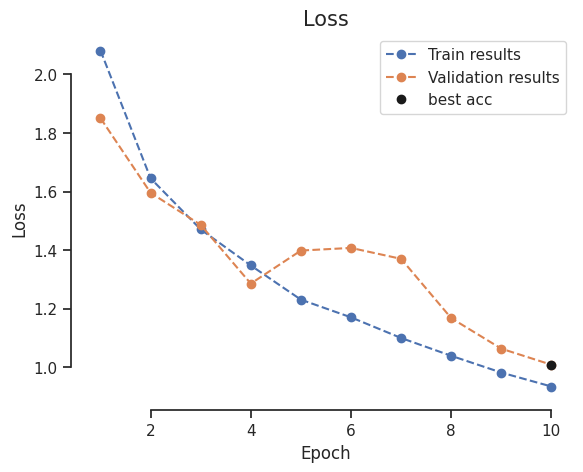

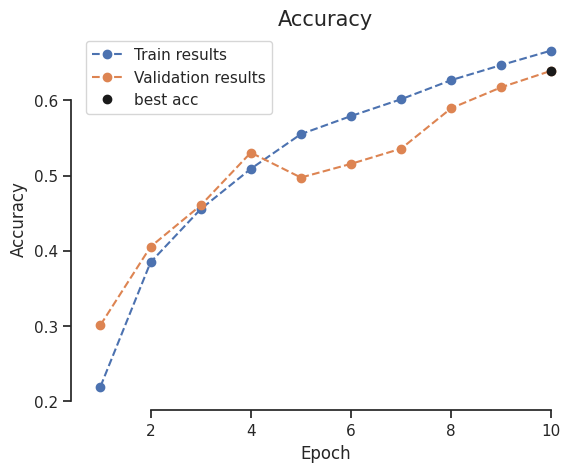

Lowest Loss.= 1.009092029929161
Max Accu.= 0.6394
64
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 14, 14]           4,736
       BatchNorm2d-2           [-1, 32, 14, 14]              64
              ReLU-3           [-1, 32, 14, 14]               0
            Conv2d-4           [-1, 32, 14, 14]           9,248
       BatchNorm2d-5           [-1, 32, 14, 14]              64
              ReLU-6           [-1, 32, 14, 14]               0
            Conv2d-7           [-1, 32, 14, 14]           9,248
       BatchNorm2d-8           [-1, 32, 14, 14]              64
              ReLU-9           [-1, 32, 14, 14]               0
    ResidualBlock-10           [-1, 32, 14, 14]               0
           Conv2d-11           [-1, 32, 14, 14]           9,248
      BatchNorm2d-12           [-1, 32, 14, 14]              64
             ReLU-13           [-1, 32, 14, 14]   

Adjusting learning rate of group 0 to 9.0000e-03.
Adjusting learning rate of group 0 to 8.1000e-03.
Adjusting learning rate of group 0 to 7.2900e-03.
Adjusting learning rate of group 0 to 6.5610e-03.
Adjusting learning rate of group 0 to 5.9049e-03.
Adjusting learning rate of group 0 to 5.3144e-03.
Adjusting learning rate of group 0 to 4.7830e-03.
Adjusting learning rate of group 0 to 4.3047e-03.
Adjusting learning rate of group 0 to 3.8742e-03.
Adjusting learning rate of group 0 to 3.4868e-03.
Finished training after 130 seconds.


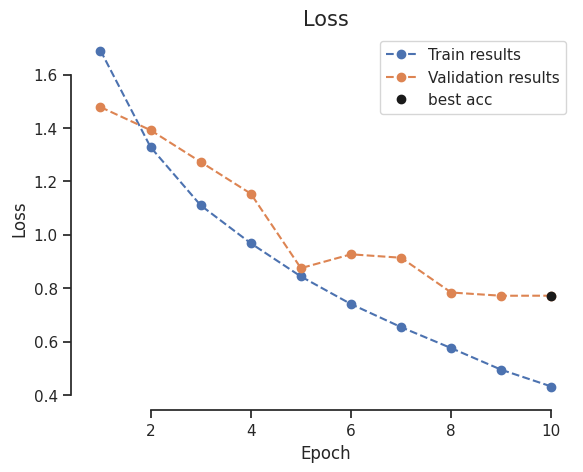

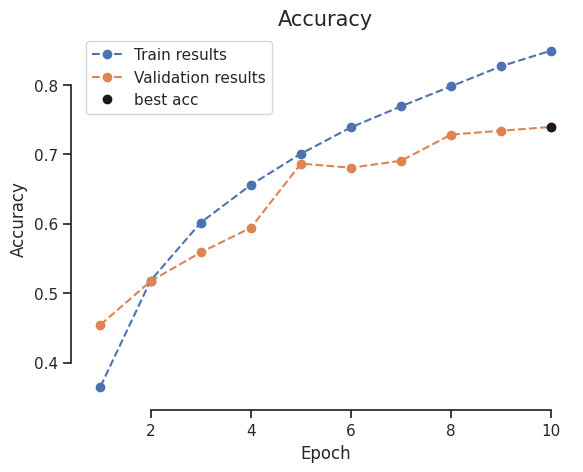

Lowest Loss.= 0.7717406488955021
Max Accu.= 0.7396


In [ ]:
# TODO train and plot with step size 1, gamma 0.9

num_epochs = 10
for lr in [0.1, 0.01]:
    # Loss and optimizer
    model = ResNet(block=ResidualBlock, layers=[2, 2]).to(device)
    summary(model, input_size=(3,32,32))
    optimizer=optim.Adam(model.parameters(),lr=lr)
    loss_function=nn.CrossEntropyLoss()


    train_losses, val_losses, train_accs, val_accs, confusion_matrix= run_training_StepLR(model, optimizer, loss_function, device, num_epochs,
                      trainloader, valloader, early_stopper=None, verbose=False, step_size=1, gamma=0.9)
    setup.plot("Loss","Loss", train_losses, val_losses, extra_pt=(val_accs.index(max(val_accs))+1, val_losses[val_accs.index(max(val_accs))]), extra_pt_label="best acc")
    setup.plot("Accuracy","Accuracy", train_accs, val_accs, extra_pt=(val_accs.index(max(val_accs))+1,max(val_accs)), extra_pt_label="best acc")

    print("Lowest Loss.=", min(val_losses))
    print("Max Accu.=", max(val_accs))


#### **TODO**

Use step size 15, gamma 0.1. Train for 30 epochs.

#### **Questions**
- Does it improve performance?
- What can you observe in the plots?

**Your answers here**

- The performance of this time is better than before with step size=1. This is mainly because the model is still trained with moderate values of learning rate.

- Here, we again observe that the scheduler cannot avoid the occurrence of overfitting as it is blind to the state of the training. We further see that right at epoch=15= step size, the loss values drop, and accuracy values suddenly rise.

64
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 14, 14]           4,736
       BatchNorm2d-2           [-1, 32, 14, 14]              64
              ReLU-3           [-1, 32, 14, 14]               0
            Conv2d-4           [-1, 32, 14, 14]           9,248
       BatchNorm2d-5           [-1, 32, 14, 14]              64
              ReLU-6           [-1, 32, 14, 14]               0
            Conv2d-7           [-1, 32, 14, 14]           9,248
       BatchNorm2d-8           [-1, 32, 14, 14]              64
              ReLU-9           [-1, 32, 14, 14]               0
    ResidualBlock-10           [-1, 32, 14, 14]               0
           Conv2d-11           [-1, 32, 14, 14]           9,248
      BatchNorm2d-12           [-1, 32, 14, 14]              64
             ReLU-13           [-1, 32, 14, 14]               0
           Conv2d-14           [-1, 

Adjusting learning rate of group 0 to 1.0000e-01.
Adjusting learning rate of group 0 to 1.0000e-01.
Adjusting learning rate of group 0 to 1.0000e-01.
Adjusting learning rate of group 0 to 1.0000e-01.
Adjusting learning rate of group 0 to 1.0000e-01.
Adjusting learning rate of group 0 to 1.0000e-01.
Adjusting learning rate of group 0 to 1.0000e-01.
Adjusting learning rate of group 0 to 1.0000e-01.
Adjusting learning rate of group 0 to 1.0000e-01.
Adjusting learning rate of group 0 to 1.0000e-01.
Adjusting learning rate of group 0 to 1.0000e-01.
Adjusting learning rate of group 0 to 1.0000e-01.
Adjusting learning rate of group 0 to 1.0000e-01.
Adjusting learning rate of group 0 to 1.0000e-01.
Adjusting learning rate of group 0 to 1.0000e-02.
Adjusting learning rate of group 0 to 1.0000e-02.
Adjusting learning rate of group 0 to 1.0000e-02.
Adjusting learning rate of group 0 to 1.0000e-02.
Adjusting learning rate of group 0 to 1.0000e-02.
Adjusting learning rate of group 0 to 1.0000e-02.


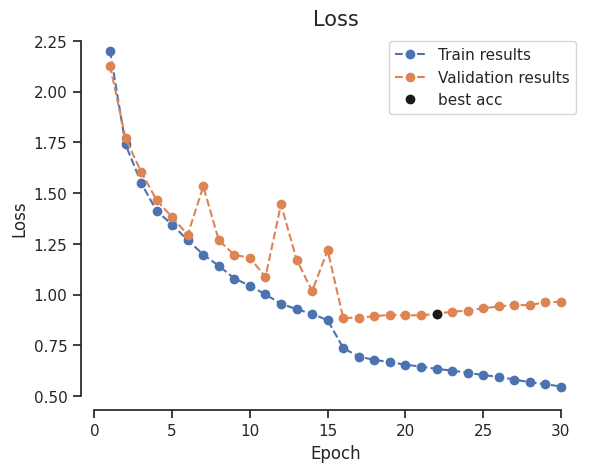

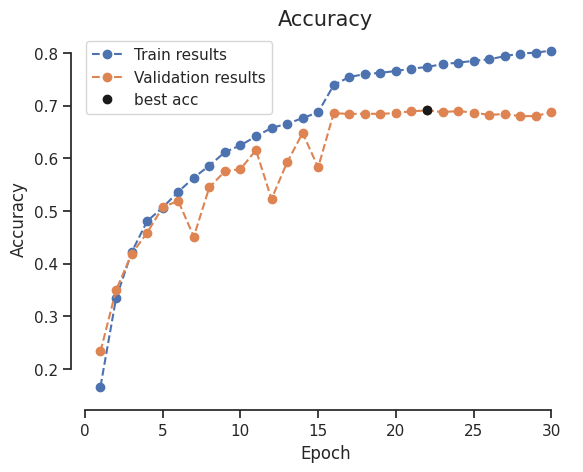

Lowest Loss.= 0.8849661514163017
Max Accu.= 0.6908
64
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 14, 14]           4,736
       BatchNorm2d-2           [-1, 32, 14, 14]              64
              ReLU-3           [-1, 32, 14, 14]               0
            Conv2d-4           [-1, 32, 14, 14]           9,248
       BatchNorm2d-5           [-1, 32, 14, 14]              64
              ReLU-6           [-1, 32, 14, 14]               0
            Conv2d-7           [-1, 32, 14, 14]           9,248
       BatchNorm2d-8           [-1, 32, 14, 14]              64
              ReLU-9           [-1, 32, 14, 14]               0
    ResidualBlock-10           [-1, 32, 14, 14]               0
           Conv2d-11           [-1, 32, 14, 14]           9,248
      BatchNorm2d-12           [-1, 32, 14, 14]              64
             ReLU-13           [-1, 32, 14, 14]  

Adjusting learning rate of group 0 to 1.0000e-02.
Adjusting learning rate of group 0 to 1.0000e-02.
Adjusting learning rate of group 0 to 1.0000e-02.
Adjusting learning rate of group 0 to 1.0000e-02.
Adjusting learning rate of group 0 to 1.0000e-02.
Adjusting learning rate of group 0 to 1.0000e-02.
Adjusting learning rate of group 0 to 1.0000e-02.
Adjusting learning rate of group 0 to 1.0000e-02.
Adjusting learning rate of group 0 to 1.0000e-02.
Adjusting learning rate of group 0 to 1.0000e-02.
Adjusting learning rate of group 0 to 1.0000e-02.
Adjusting learning rate of group 0 to 1.0000e-02.
Adjusting learning rate of group 0 to 1.0000e-02.
Adjusting learning rate of group 0 to 1.0000e-02.
Adjusting learning rate of group 0 to 1.0000e-03.
Adjusting learning rate of group 0 to 1.0000e-03.
Adjusting learning rate of group 0 to 1.0000e-03.
Adjusting learning rate of group 0 to 1.0000e-03.
Adjusting learning rate of group 0 to 1.0000e-03.
Adjusting learning rate of group 0 to 1.0000e-03.


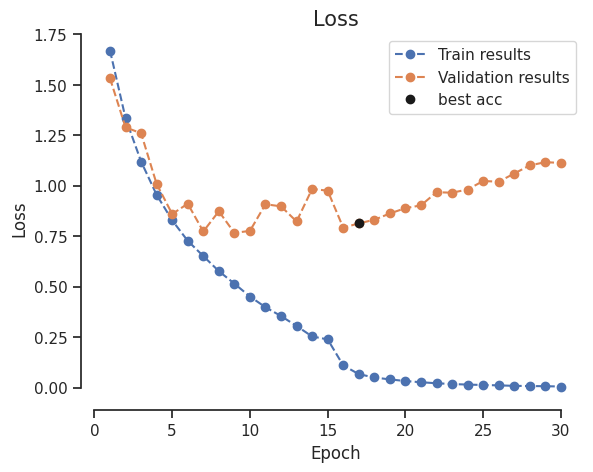

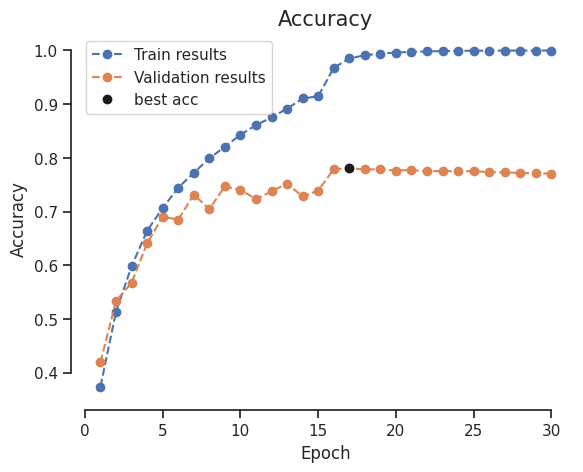

Lowest Loss.= 0.7670351698994636
Max Accu.= 0.7808


In [ ]:
# TODO train and plot with step size 15, gamma 0.1, 30 epochs.

num_epochs = 30
lr = 0.001

for lr in [0.1, 0.01]:
    # Loss and optimizer
    model = ResNet(block=ResidualBlock, layers=[2, 2]).to(device)
    summary(model, input_size=(3,32,32))
    optimizer=optim.Adam(model.parameters(),lr=lr)
    loss_function=nn.CrossEntropyLoss()


    train_losses, val_losses, train_accs, val_accs, confusion_matrix= run_training_StepLR(model, optimizer, loss_function, device, num_epochs,
                      trainloader, valloader, early_stopper=None, verbose=False, step_size=15, gamma=0.1)
    setup.plot("Loss","Loss", train_losses, val_losses, extra_pt=(val_accs.index(max(val_accs))+1, val_losses[val_accs.index(max(val_accs))]), extra_pt_label="best acc")
    setup.plot("Accuracy","Accuracy", train_accs, val_accs, extra_pt=(val_accs.index(max(val_accs))+1,max(val_accs)), extra_pt_label="best acc")

    print("Lowest Loss.=", min(val_losses))
    print("Max Accu.=", max(val_accs))


## [7. Optional LR-Scheduling]

#### **TODO**
- try two more scheduler: ExponentialLR and ReduceLROnPlateau
- vary the parameters, which work best?
- does it improve performance compared to no scheduler?
- does it improve performance compared to StepLR?

**Your answers here**

- The accuracy that we obtained using StepLR was slightly better than using ExponentialLR for gamma=0.9. For small gamma values, both models ceased being trained. ReduceLROnPlateau monitors the training curves and reduces step size accordingly. In this respect, the learning rate is tailored dynamically.

- If our model does not experience overfitting, having a scheduler can improve the final accuracy.

- Based on the final accuracy and for initial lr=1e-3, the best accuracy of StepLR is 0.77, the best accuracy of ReduceLROnPlateau with patience=1 is 0.76, and the best accuracy of ExponentialLR is 0.74.

In [ ]:
# TODO change run_training (you can copy the code from setup.py here and create a new method here
# or just change/create a new method it in the python file)

def run_training_ExponentialLR(model, optimizer, loss_function, device, num_epochs,
                train_dataloader, val_dataloader, early_stopper=None, verbose=False,
                             gamma=0.8):
    """Run model training.

    Args:
        model (nn.Module): Torch model to train
        optimizer: Torch optimizer object
        loss_fn: Torch loss function for training
        device (torch.device): Torch device to use for training
        num_epochs (int): Max. number of epochs to train
        train_dataloader (DataLoader): Torch DataLoader object to load the
            training data
        val_dataloader (DataLoader): Torch DataLoader object to load the
            validation data
        early_stopper (EarlyStopper, optional): If passed, model will be trained
            with early stopping. Defaults to None.
        verbose (bool, optional): Print information about model training.
            Defaults to False.

    Returns:
        list, list, list, list, torch.Tensor shape (10,10): Return list of train
            losses, validation losses, train accuracies, validation accuracies
            per epoch and the confusion matrix evaluated in the last epoch.
    """
    start_time = time.time()
    master_bar = fastprogress.master_bar(range(num_epochs))
    train_losses, val_losses, train_accs, val_accs = [],[],[],[]

    scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma, verbose=True)
    for epoch in master_bar:
        # Train the model
        epoch_train_loss, epoch_train_acc = setup.train(train_dataloader, optimizer, model,
                                                  loss_function, device, master_bar)

        scheduler.step() # usually scheduler should be called after train/optimizer
        # Validate the model
        epoch_val_loss, epoch_val_acc, confusion_matrix = setup.validate(val_dataloader,
                                                                   model, loss_function,
                                                                   device, master_bar)

        # Save loss and acc for plotting
        train_losses.append(epoch_train_loss)
        val_losses.append(epoch_val_loss)
        train_accs.append(epoch_train_acc)
        val_accs.append(epoch_val_acc)

        if verbose:
            master_bar.write(f'Train loss: {epoch_train_loss:.2f}, val loss: {epoch_val_loss:.2f}, train acc: {epoch_train_acc:.3f}, val acc {epoch_val_acc:.3f}')

        if early_stopper:
            early_stopper.update(epoch_val_acc, model)
            if early_stopper.early_stop:
                model = early_stopper.load_checkpoint(model)
                print('early stopping')
                break
            # END OF YOUR CODE #

    time_elapsed = np.round(time.time() - start_time, 0).astype(int)
    print(f'Finished training after {time_elapsed} seconds.')
    return train_losses, val_losses, train_accs, val_accs, confusion_matrix


gamma=  0.1
64
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 14, 14]           4,736
       BatchNorm2d-2           [-1, 32, 14, 14]              64
              ReLU-3           [-1, 32, 14, 14]               0
            Conv2d-4           [-1, 32, 14, 14]           9,248
       BatchNorm2d-5           [-1, 32, 14, 14]              64
              ReLU-6           [-1, 32, 14, 14]               0
            Conv2d-7           [-1, 32, 14, 14]           9,248
       BatchNorm2d-8           [-1, 32, 14, 14]              64
              ReLU-9           [-1, 32, 14, 14]               0
    ResidualBlock-10           [-1, 32, 14, 14]               0
           Conv2d-11           [-1, 32, 14, 14]           9,248
      BatchNorm2d-12           [-1, 32, 14, 14]              64
             ReLU-13           [-1, 32, 14, 14]               0
           Conv2d-14    

Adjusting learning rate of group 0 to 1.0000e-02.
Adjusting learning rate of group 0 to 1.0000e-03.
Adjusting learning rate of group 0 to 1.0000e-04.
Adjusting learning rate of group 0 to 1.0000e-05.
Adjusting learning rate of group 0 to 1.0000e-06.
Adjusting learning rate of group 0 to 1.0000e-07.
Adjusting learning rate of group 0 to 1.0000e-08.
Adjusting learning rate of group 0 to 1.0000e-09.
Adjusting learning rate of group 0 to 1.0000e-10.
Adjusting learning rate of group 0 to 1.0000e-11.
Adjusting learning rate of group 0 to 1.0000e-12.
Adjusting learning rate of group 0 to 1.0000e-13.
Adjusting learning rate of group 0 to 1.0000e-14.
Adjusting learning rate of group 0 to 1.0000e-15.
Adjusting learning rate of group 0 to 1.0000e-16.
Adjusting learning rate of group 0 to 1.0000e-17.
Adjusting learning rate of group 0 to 1.0000e-18.
Adjusting learning rate of group 0 to 1.0000e-19.
Adjusting learning rate of group 0 to 1.0000e-20.
Adjusting learning rate of group 0 to 1.0000e-21.


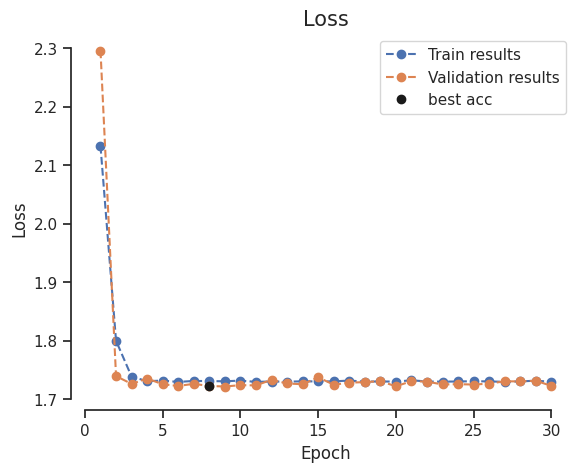

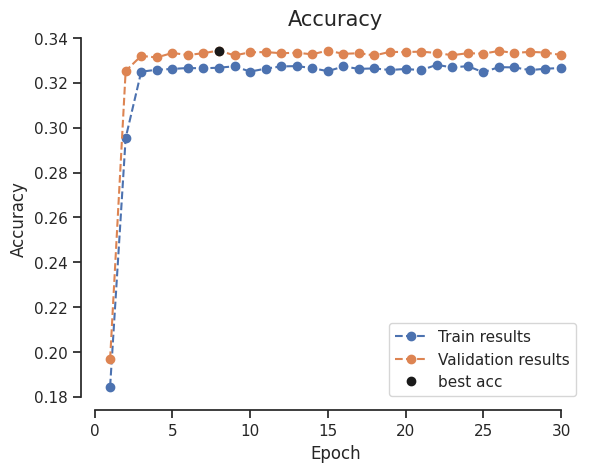

Lowest Loss.= 1.721852195262909
Max Accu.= 0.3344
gamma=  0.9
64
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 14, 14]           4,736
       BatchNorm2d-2           [-1, 32, 14, 14]              64
              ReLU-3           [-1, 32, 14, 14]               0
            Conv2d-4           [-1, 32, 14, 14]           9,248
       BatchNorm2d-5           [-1, 32, 14, 14]              64
              ReLU-6           [-1, 32, 14, 14]               0
            Conv2d-7           [-1, 32, 14, 14]           9,248
       BatchNorm2d-8           [-1, 32, 14, 14]              64
              ReLU-9           [-1, 32, 14, 14]               0
    ResidualBlock-10           [-1, 32, 14, 14]               0
           Conv2d-11           [-1, 32, 14, 14]           9,248
      BatchNorm2d-12           [-1, 32, 14, 14]              64
             ReLU-13           [-1, 32

Adjusting learning rate of group 0 to 9.0000e-02.
Adjusting learning rate of group 0 to 8.1000e-02.
Adjusting learning rate of group 0 to 7.2900e-02.
Adjusting learning rate of group 0 to 6.5610e-02.
Adjusting learning rate of group 0 to 5.9049e-02.
Adjusting learning rate of group 0 to 5.3144e-02.
Adjusting learning rate of group 0 to 4.7830e-02.
Adjusting learning rate of group 0 to 4.3047e-02.
Adjusting learning rate of group 0 to 3.8742e-02.
Adjusting learning rate of group 0 to 3.4868e-02.
Adjusting learning rate of group 0 to 3.1381e-02.
Adjusting learning rate of group 0 to 2.8243e-02.
Adjusting learning rate of group 0 to 2.5419e-02.
Adjusting learning rate of group 0 to 2.2877e-02.
Adjusting learning rate of group 0 to 2.0589e-02.
Adjusting learning rate of group 0 to 1.8530e-02.
Adjusting learning rate of group 0 to 1.6677e-02.
Adjusting learning rate of group 0 to 1.5009e-02.
Adjusting learning rate of group 0 to 1.3509e-02.
Adjusting learning rate of group 0 to 1.2158e-02.


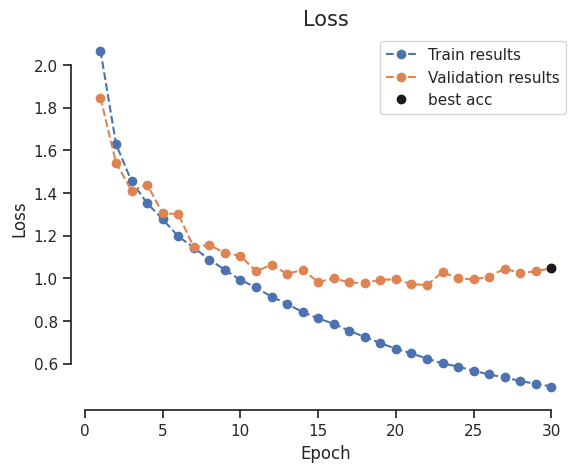

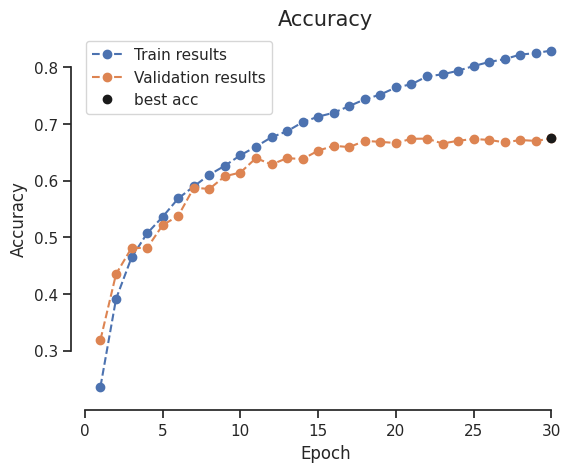

Lowest Loss.= 0.9680258482694626
Max Accu.= 0.6743
gamma=  0.1
64
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 14, 14]           4,736
       BatchNorm2d-2           [-1, 32, 14, 14]              64
              ReLU-3           [-1, 32, 14, 14]               0
            Conv2d-4           [-1, 32, 14, 14]           9,248
       BatchNorm2d-5           [-1, 32, 14, 14]              64
              ReLU-6           [-1, 32, 14, 14]               0
            Conv2d-7           [-1, 32, 14, 14]           9,248
       BatchNorm2d-8           [-1, 32, 14, 14]              64
              ReLU-9           [-1, 32, 14, 14]               0
    ResidualBlock-10           [-1, 32, 14, 14]               0
           Conv2d-11           [-1, 32, 14, 14]           9,248
      BatchNorm2d-12           [-1, 32, 14, 14]              64
             ReLU-13           [-1, 3

Adjusting learning rate of group 0 to 1.0000e-04.
Adjusting learning rate of group 0 to 1.0000e-05.
Adjusting learning rate of group 0 to 1.0000e-06.
Adjusting learning rate of group 0 to 1.0000e-07.
Adjusting learning rate of group 0 to 1.0000e-08.
Adjusting learning rate of group 0 to 1.0000e-09.
Adjusting learning rate of group 0 to 1.0000e-10.
Adjusting learning rate of group 0 to 1.0000e-11.
Adjusting learning rate of group 0 to 1.0000e-12.
Adjusting learning rate of group 0 to 1.0000e-13.
Adjusting learning rate of group 0 to 1.0000e-14.
Adjusting learning rate of group 0 to 1.0000e-15.
Adjusting learning rate of group 0 to 1.0000e-16.
Adjusting learning rate of group 0 to 1.0000e-17.
Adjusting learning rate of group 0 to 1.0000e-18.
Adjusting learning rate of group 0 to 1.0000e-19.
Adjusting learning rate of group 0 to 1.0000e-20.
Adjusting learning rate of group 0 to 1.0000e-21.
Adjusting learning rate of group 0 to 1.0000e-22.
Adjusting learning rate of group 0 to 1.0000e-23.


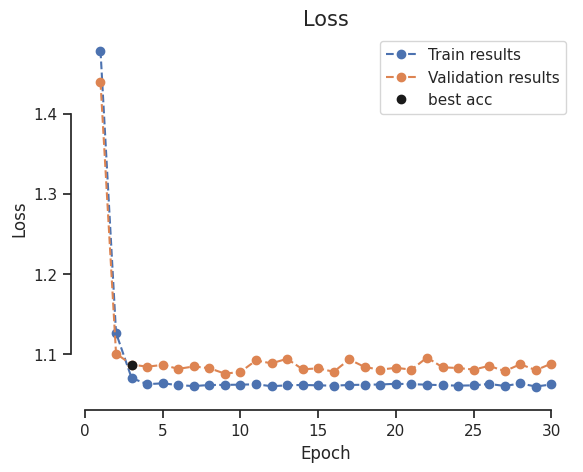

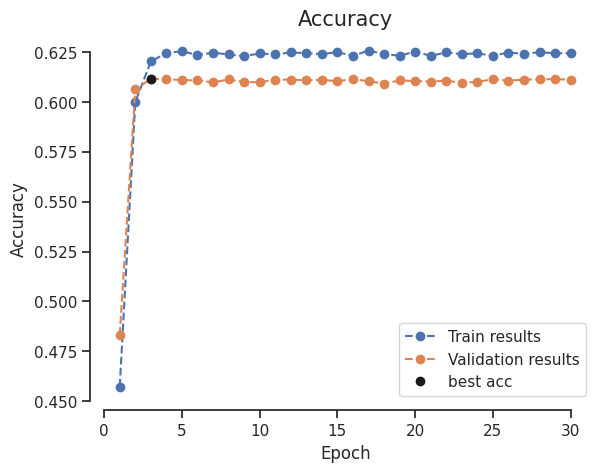

Lowest Loss.= 1.075580883026123
Max Accu.= 0.6116
gamma=  0.9
64
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 14, 14]           4,736
       BatchNorm2d-2           [-1, 32, 14, 14]              64
              ReLU-3           [-1, 32, 14, 14]               0
            Conv2d-4           [-1, 32, 14, 14]           9,248
       BatchNorm2d-5           [-1, 32, 14, 14]              64
              ReLU-6           [-1, 32, 14, 14]               0
            Conv2d-7           [-1, 32, 14, 14]           9,248
       BatchNorm2d-8           [-1, 32, 14, 14]              64
              ReLU-9           [-1, 32, 14, 14]               0
    ResidualBlock-10           [-1, 32, 14, 14]               0
           Conv2d-11           [-1, 32, 14, 14]           9,248
      BatchNorm2d-12           [-1, 32, 14, 14]              64
             ReLU-13           [-1, 32

Adjusting learning rate of group 0 to 9.0000e-04.
Adjusting learning rate of group 0 to 8.1000e-04.
Adjusting learning rate of group 0 to 7.2900e-04.
Adjusting learning rate of group 0 to 6.5610e-04.
Adjusting learning rate of group 0 to 5.9049e-04.
Adjusting learning rate of group 0 to 5.3144e-04.
Adjusting learning rate of group 0 to 4.7830e-04.
Adjusting learning rate of group 0 to 4.3047e-04.
Adjusting learning rate of group 0 to 3.8742e-04.
Adjusting learning rate of group 0 to 3.4868e-04.
Adjusting learning rate of group 0 to 3.1381e-04.
Adjusting learning rate of group 0 to 2.8243e-04.
Adjusting learning rate of group 0 to 2.5419e-04.
Adjusting learning rate of group 0 to 2.2877e-04.
Adjusting learning rate of group 0 to 2.0589e-04.
Adjusting learning rate of group 0 to 1.8530e-04.
Adjusting learning rate of group 0 to 1.6677e-04.
Adjusting learning rate of group 0 to 1.5009e-04.
Adjusting learning rate of group 0 to 1.3509e-04.
Adjusting learning rate of group 0 to 1.2158e-04.


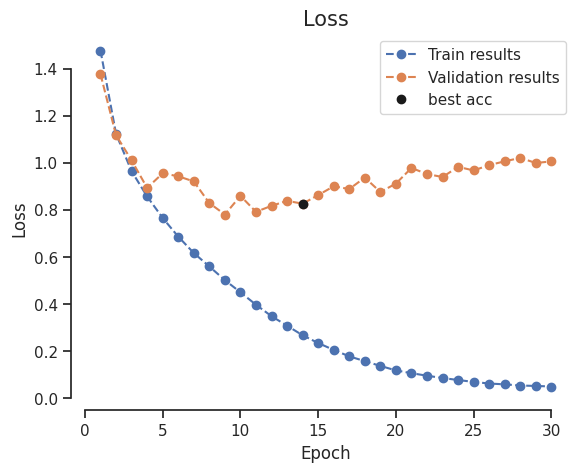

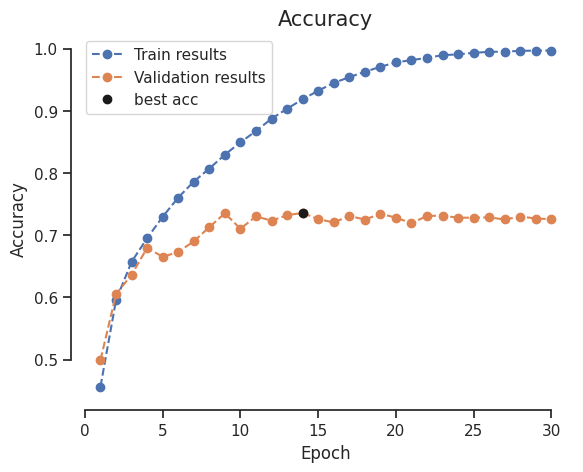

Lowest Loss.= 0.7800521582365036
Max Accu.= 0.7359


In [ ]:
# TODO train and plot with  ExponentialLR schedulers

num_epochs = 30
lr = 0.001

for lr in [1e-1, 1e-3]:
    for gamma in [0.1, 0.9]:
        print("gamma= ", gamma)
        # Loss and optimizer
        model = ResNet(block=ResidualBlock, layers=[2, 2]).to(device)
        summary(model, input_size=(3,32,32))
        optimizer=optim.Adam(model.parameters(),lr=lr)
        loss_function=nn.CrossEntropyLoss()

        earlystop = setup.EarlyStopper(verbose=False, path='checkpoint.pt', patience=10)
        train_losses, val_losses, train_accs, val_accs, confusion_matrix= run_training_ExponentialLR(model, optimizer, loss_function, device, num_epochs,
                          trainloader, valloader, early_stopper=earlystop, verbose=False, gamma=gamma)
        setup.plot("Loss","Loss", train_losses, val_losses, extra_pt=(val_accs.index(max(val_accs))+1, val_losses[val_accs.index(max(val_accs))]), extra_pt_label="best acc")
        setup.plot("Accuracy","Accuracy", train_accs, val_accs, extra_pt=(val_accs.index(max(val_accs))+1,max(val_accs)), extra_pt_label="best acc")

        print("Lowest Loss.=", min(val_losses))
        print("Max Accu.=", max(val_accs))


In [ ]:
# TODO change run_training (you can copy the code from setup.py here and create a new method here
# or just change/create a new method it in the python file)

def run_training_ReduceLROnPlateau(model, optimizer, loss_function, device, num_epochs,
                train_dataloader, val_dataloader, early_stopper=None, verbose=False):
    """Run model training.

    Args:
        model (nn.Module): Torch model to train
        optimizer: Torch optimizer object
        loss_fn: Torch loss function for training
        device (torch.device): Torch device to use for training
        num_epochs (int): Max. number of epochs to train
        train_dataloader (DataLoader): Torch DataLoader object to load the
            training data
        val_dataloader (DataLoader): Torch DataLoader object to load the
            validation data
        early_stopper (EarlyStopper, optional): If passed, model will be trained
            with early stopping. Defaults to None.
        verbose (bool, optional): Print information about model training.
            Defaults to False.

    Returns:
        list, list, list, list, torch.Tensor shape (10,10): Return list of train
            losses, validation losses, train accuracies, validation accuracies
            per epoch and the confusion matrix evaluated in the last epoch.
    """
    start_time = time.time()
    master_bar = fastprogress.master_bar(range(num_epochs))
    train_losses, val_losses, train_accs, val_accs = [],[],[],[]

    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=1, verbose=True)
    for epoch in master_bar:
        # Train the model
        epoch_train_loss, epoch_train_acc = setup.train(train_dataloader, optimizer, model,
                                                  loss_function, device, master_bar)

        # Validate the model
        epoch_val_loss, epoch_val_acc, confusion_matrix = setup.validate(val_dataloader,
                                                                   model, loss_function,
                                                                   device, master_bar)
        scheduler.step(epoch_val_loss) # this scheduler should be called after validate
        # Save loss and acc for plotting
        train_losses.append(epoch_train_loss)
        val_losses.append(epoch_val_loss)
        train_accs.append(epoch_train_acc)
        val_accs.append(epoch_val_acc)

        if verbose:
            master_bar.write(f'Train loss: {epoch_train_loss:.2f}, val loss: {epoch_val_loss:.2f}, train acc: {epoch_train_acc:.3f}, val acc {epoch_val_acc:.3f}')

        if early_stopper:
            early_stopper.update(epoch_val_acc, model)
            if early_stopper.early_stop:
                model = early_stopper.load_checkpoint(model)
                print('early stopping')
                break
            # END OF YOUR CODE #

    time_elapsed = np.round(time.time() - start_time, 0).astype(int)
    print(f'Finished training after {time_elapsed} seconds.')
    return train_losses, val_losses, train_accs, val_accs, confusion_matrix


64
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 14, 14]           4,736
       BatchNorm2d-2           [-1, 32, 14, 14]              64
              ReLU-3           [-1, 32, 14, 14]               0
            Conv2d-4           [-1, 32, 14, 14]           9,248
       BatchNorm2d-5           [-1, 32, 14, 14]              64
              ReLU-6           [-1, 32, 14, 14]               0
            Conv2d-7           [-1, 32, 14, 14]           9,248
       BatchNorm2d-8           [-1, 32, 14, 14]              64
              ReLU-9           [-1, 32, 14, 14]               0
    ResidualBlock-10           [-1, 32, 14, 14]               0
           Conv2d-11           [-1, 32, 14, 14]           9,248
      BatchNorm2d-12           [-1, 32, 14, 14]              64
             ReLU-13           [-1, 32, 14, 14]               0
           Conv2d-14           [-1, 

Epoch 00007: reducing learning rate of group 0 to 1.0000e-02.
Epoch 00016: reducing learning rate of group 0 to 1.0000e-03.
Epoch 00021: reducing learning rate of group 0 to 1.0000e-04.
Epoch 00023: reducing learning rate of group 0 to 1.0000e-05.
Epoch 00026: reducing learning rate of group 0 to 1.0000e-06.
Epoch 00028: reducing learning rate of group 0 to 1.0000e-07.
Epoch 00030: reducing learning rate of group 0 to 1.0000e-08.
Finished training after 391 seconds.


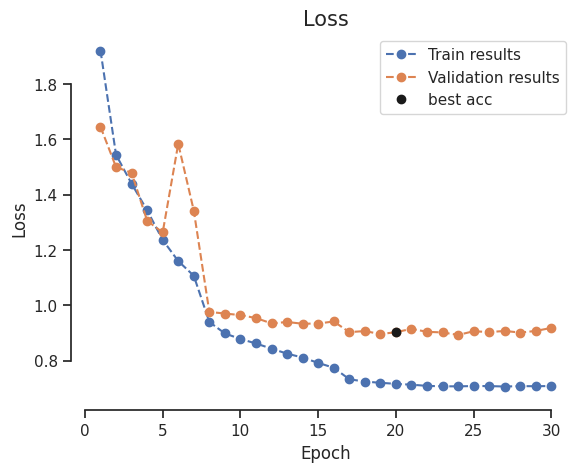

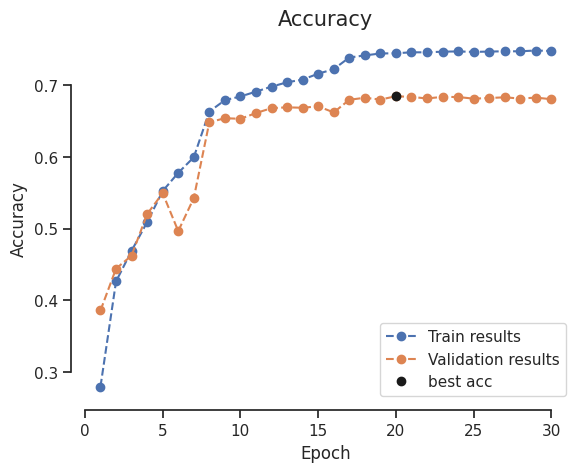

Lowest Loss.= 0.8929509356617927
Max Accu.= 0.6849
64
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 14, 14]           4,736
       BatchNorm2d-2           [-1, 32, 14, 14]              64
              ReLU-3           [-1, 32, 14, 14]               0
            Conv2d-4           [-1, 32, 14, 14]           9,248
       BatchNorm2d-5           [-1, 32, 14, 14]              64
              ReLU-6           [-1, 32, 14, 14]               0
            Conv2d-7           [-1, 32, 14, 14]           9,248
       BatchNorm2d-8           [-1, 32, 14, 14]              64
              ReLU-9           [-1, 32, 14, 14]               0
    ResidualBlock-10           [-1, 32, 14, 14]               0
           Conv2d-11           [-1, 32, 14, 14]           9,248
      BatchNorm2d-12           [-1, 32, 14, 14]              64
             ReLU-13           [-1, 32, 14, 14]  

Epoch 00007: reducing learning rate of group 0 to 1.0000e-04.
Epoch 00012: reducing learning rate of group 0 to 1.0000e-05.
Epoch 00014: reducing learning rate of group 0 to 1.0000e-06.
Epoch 00017: reducing learning rate of group 0 to 1.0000e-07.
Epoch 00019: reducing learning rate of group 0 to 1.0000e-08.
Finished training after 397 seconds.


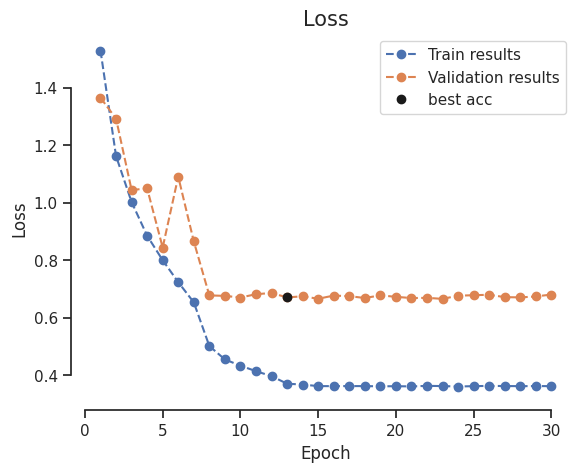

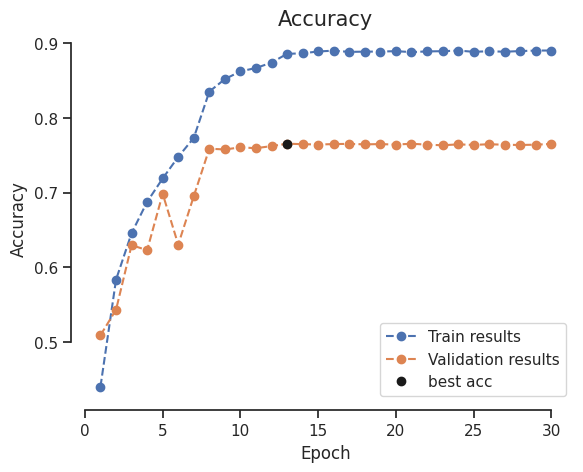

Lowest Loss.= 0.6648747146129608
Max Accu.= 0.7655


In [ ]:
# TODO train and plot with  ReduceLROnPlateau schedulers

num_epochs = 30
lr = 0.001

for lr in [1e-1, 1e-3]:
    # Loss and optimizer
    model = ResNet(block=ResidualBlock, layers=[2, 2]).to(device)
    summary(model, input_size=(3,32,32))
    optimizer=optim.Adam(model.parameters(),lr=lr)
    loss_function=nn.CrossEntropyLoss()

    earlystop = setup.EarlyStopper(verbose=False, path='checkpoint.pt', patience=10)
    train_losses, val_losses, train_accs, val_accs, confusion_matrix= run_training_ReduceLROnPlateau(model, optimizer, loss_function, device, num_epochs,
                      trainloader, valloader, early_stopper=earlystop, verbose=False)
    setup.plot("Loss","Loss", train_losses, val_losses, extra_pt=(val_accs.index(max(val_accs))+1, val_losses[val_accs.index(max(val_accs))]), extra_pt_label="best acc")
    setup.plot("Accuracy","Accuracy", train_accs, val_accs, extra_pt=(val_accs.index(max(val_accs))+1,max(val_accs)), extra_pt_label="best acc")

    print("Lowest Loss.=", min(val_losses))
    print("Max Accu.=", max(val_accs))


In [ ]:
# Here we have combined two scheduler learning rates

def run_training_twoschedulerLR(model, optimizer, loss_function, device, num_epochs,
                train_dataloader, val_dataloader, early_stopper=None, verbose=False,
                      gamma1=0.95, gamma2=0.8,milestones=[30]):
    """Run model training.

    Args:
        model (nn.Module): Torch model to train
        optimizer: Torch optimizer object
        loss_fn: Torch loss function for training
        device (torch.device): Torch device to use for training
        num_epochs (int): Max. number of epochs to train
        train_dataloader (DataLoader): Torch DataLoader object to load the
            training data
        val_dataloader (DataLoader): Torch DataLoader object to load the
            validation data
        early_stopper (EarlyStopper, optional): If passed, model will be trained
            with early stopping. Defaults to None.
        verbose (bool, optional): Print information about model training.
            Defaults to False.

    Returns:
        list, list, list, list, torch.Tensor shape (10,10): Return list of train
            losses, validation losses, train accuracies, validation accuracies
            per epoch and the confusion matrix evaluated in the last epoch.
    """
    start_time = time.time()
    master_bar = fastprogress.master_bar(range(num_epochs))
    train_losses, val_losses, train_accs, val_accs = [],[],[],[]

    scheduler1 = optim.lr_scheduler.ExponentialLR(optimizer, gamma=gamma1, verbose=True)
    scheduler2 = optim.lr_scheduler.MultiStepLR(optimizer, milestones=milestones,
                                                gamma=gamma2, verbose=True)

    for epoch in master_bar:
        # Train the model
        epoch_train_loss, epoch_train_acc = setup.train(train_dataloader, optimizer, model,
                                                  loss_function, device, master_bar)

        scheduler1.step()
        scheduler2.step()
        # Validate the model
        epoch_val_loss, epoch_val_acc, confusion_matrix = setup.validate(val_dataloader,
                                                                   model, loss_function,
                                                                   device, master_bar)
        # Save loss and acc for plotting
        train_losses.append(epoch_train_loss)
        val_losses.append(epoch_val_loss)
        train_accs.append(epoch_train_acc)
        val_accs.append(epoch_val_acc)

        if verbose:
            master_bar.write(f'Train loss: {epoch_train_loss:.2f}, val loss: {epoch_val_loss:.2f}, train acc: {epoch_train_acc:.3f}, val acc {epoch_val_acc:.3f}')

        if early_stopper:
            early_stopper.update(epoch_val_acc, model)
            if early_stopper.early_stop:
                model = early_stopper.load_checkpoint(model)
                print('early stopping')
                break
            # END OF YOUR CODE #

    time_elapsed = np.round(time.time() - start_time, 0).astype(int)
    print(f'Finished training after {time_elapsed} seconds.')
    return train_losses, val_losses, train_accs, val_accs, confusion_matrix


64
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 14, 14]           4,736
       BatchNorm2d-2           [-1, 32, 14, 14]              64
              ReLU-3           [-1, 32, 14, 14]               0
            Conv2d-4           [-1, 32, 14, 14]           9,248
       BatchNorm2d-5           [-1, 32, 14, 14]              64
              ReLU-6           [-1, 32, 14, 14]               0
            Conv2d-7           [-1, 32, 14, 14]           9,248
       BatchNorm2d-8           [-1, 32, 14, 14]              64
              ReLU-9           [-1, 32, 14, 14]               0
    ResidualBlock-10           [-1, 32, 14, 14]               0
           Conv2d-11           [-1, 32, 14, 14]           9,248
      BatchNorm2d-12           [-1, 32, 14, 14]              64
             ReLU-13           [-1, 32, 14, 14]               0
           Conv2d-14           [-1, 

Adjusting learning rate of group 0 to 9.5000e-02.
Adjusting learning rate of group 0 to 9.5000e-02.
Adjusting learning rate of group 0 to 9.0250e-02.
Adjusting learning rate of group 0 to 9.0250e-02.
Adjusting learning rate of group 0 to 8.5737e-02.
Adjusting learning rate of group 0 to 8.5737e-02.
Adjusting learning rate of group 0 to 8.1451e-02.
Adjusting learning rate of group 0 to 8.1451e-02.
Adjusting learning rate of group 0 to 7.7378e-02.
Adjusting learning rate of group 0 to 7.7378e-02.
Adjusting learning rate of group 0 to 7.3509e-02.
Adjusting learning rate of group 0 to 7.3509e-02.
Adjusting learning rate of group 0 to 6.9834e-02.
Adjusting learning rate of group 0 to 5.5867e-02.
Adjusting learning rate of group 0 to 5.3074e-02.
Adjusting learning rate of group 0 to 5.3074e-02.
Adjusting learning rate of group 0 to 5.0420e-02.
Adjusting learning rate of group 0 to 5.0420e-02.
Adjusting learning rate of group 0 to 4.7899e-02.
Adjusting learning rate of group 0 to 4.7899e-02.


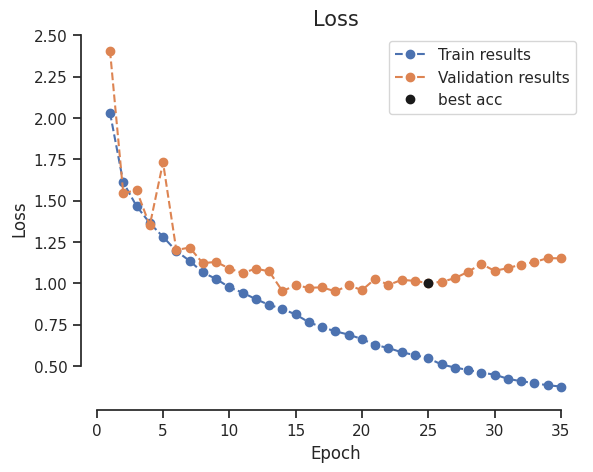

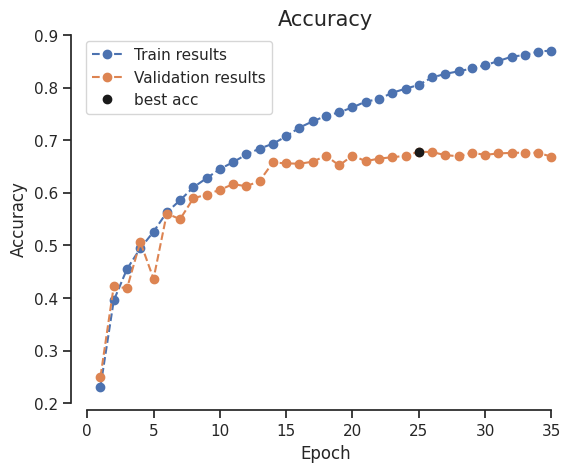

Lowest Loss.= 0.950569000840187
Max Accu.= 0.6781
64
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 14, 14]           4,736
       BatchNorm2d-2           [-1, 32, 14, 14]              64
              ReLU-3           [-1, 32, 14, 14]               0
            Conv2d-4           [-1, 32, 14, 14]           9,248
       BatchNorm2d-5           [-1, 32, 14, 14]              64
              ReLU-6           [-1, 32, 14, 14]               0
            Conv2d-7           [-1, 32, 14, 14]           9,248
       BatchNorm2d-8           [-1, 32, 14, 14]              64
              ReLU-9           [-1, 32, 14, 14]               0
    ResidualBlock-10           [-1, 32, 14, 14]               0
           Conv2d-11           [-1, 32, 14, 14]           9,248
      BatchNorm2d-12           [-1, 32, 14, 14]              64
             ReLU-13           [-1, 32, 14, 14]   

Adjusting learning rate of group 0 to 9.5000e-04.
Adjusting learning rate of group 0 to 9.5000e-04.
Adjusting learning rate of group 0 to 9.0250e-04.
Adjusting learning rate of group 0 to 9.0250e-04.
Adjusting learning rate of group 0 to 8.5737e-04.
Adjusting learning rate of group 0 to 8.5737e-04.
Adjusting learning rate of group 0 to 8.1451e-04.
Adjusting learning rate of group 0 to 8.1451e-04.
Adjusting learning rate of group 0 to 7.7378e-04.
Adjusting learning rate of group 0 to 7.7378e-04.
Adjusting learning rate of group 0 to 7.3509e-04.
Adjusting learning rate of group 0 to 7.3509e-04.
Adjusting learning rate of group 0 to 6.9834e-04.
Adjusting learning rate of group 0 to 5.5867e-04.
Adjusting learning rate of group 0 to 5.3074e-04.
Adjusting learning rate of group 0 to 5.3074e-04.
Adjusting learning rate of group 0 to 5.0420e-04.
Adjusting learning rate of group 0 to 5.0420e-04.
Adjusting learning rate of group 0 to 4.7899e-04.
Adjusting learning rate of group 0 to 4.7899e-04.


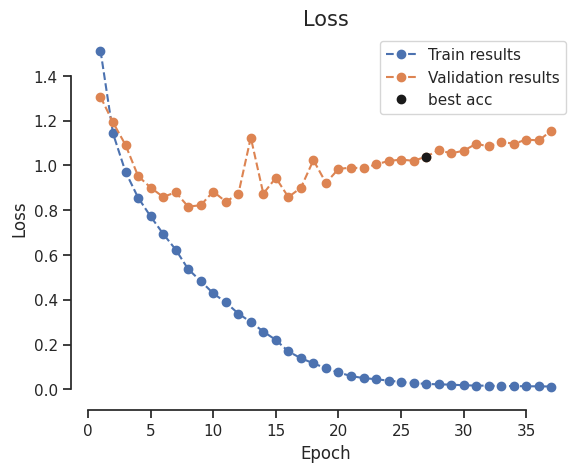

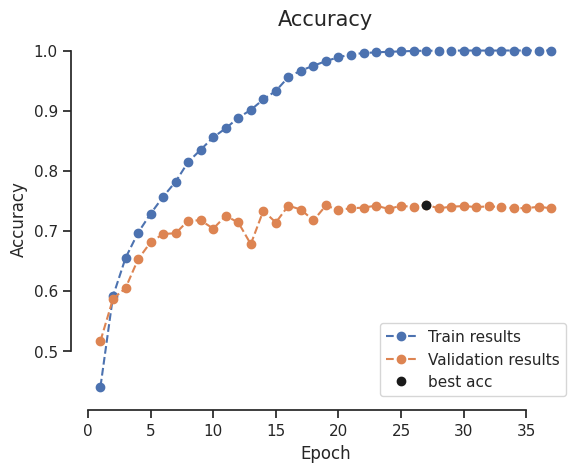

Lowest Loss.= 0.8163489863276482
Max Accu.= 0.7431


In [ ]:
# TODO train and plot with  ExponentialLR and multistepLR schedulers

num_epochs = 100
lr = 0.001

for lr in [1e-1, 1e-3]:
    # Loss and optimizer
    model = ResNet(block=ResidualBlock, layers=[2, 2]).to(device)
    summary(model, input_size=(3,32,32))
    optimizer=optim.Adam(model.parameters(),lr=lr)
    loss_function=nn.CrossEntropyLoss()

    earlystop = setup.EarlyStopper(verbose=False, path='checkpoint.pt', patience=10)
    train_losses, val_losses, train_accs, val_accs, confusion_matrix= run_training_twoschedulerLR(model, optimizer, loss_function, device, num_epochs,
                      trainloader, valloader, early_stopper=earlystop, verbose=False, gamma1=0.95, gamma2=0.8,milestones=[7,15,20,25,30])
    setup.plot("Loss","Loss", train_losses, val_losses, extra_pt=(val_accs.index(max(val_accs))+1, val_losses[val_accs.index(max(val_accs))]), extra_pt_label="best acc")
    setup.plot("Accuracy","Accuracy", train_accs, val_accs, extra_pt=(val_accs.index(max(val_accs))+1,max(val_accs)), extra_pt_label="best acc")

    print("Lowest Loss.=", min(val_losses))
    print("Max Accu.=", max(val_accs))
